# Model Factory

In [156]:
import os, sys, math, datetime, csv
import psutil
import configparser

# import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL

import PIL.Image
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
#%reload_ext autoreload
%autoreload

In [158]:

import tensorflow as tf
import tensorflow_datasets as tfds

# see https://github.com/microsoft/pylance-release/issues/1066
#from tensorflow import keras
keras = tf.keras
from keras.layers import (
    Input,
    Dense,
    Add,
    Multiply,
    Flatten,
    Conv2D,
    Dropout,
    Reshape,
    Activation,
    DepthwiseConv2D,
    MaxPooling2D,
    AvgPool2D,
    AveragePooling2D,
    GlobalAveragePooling2D,
    Softmax,
    BatchNormalization,
    Concatenate,
    Permute,
    ReLU,
    LeakyReLU
)

from keras.models import Model
from keras.regularizers import l2
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#from dotenv import load_dotenv
#from tf2cv.model_provider import get_model as tf2cv_get_model

# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model

from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths, get_file_size, create_model_name, append_dict_to_csv
from workbench.tensorflow import set_batchnorm_momentum, set_dropout
from workbench.data.data import get_vvw_dataset, get_vvw_minval_dataset, get_lemon_binary_datagen

from workbench.models.efficientnet_lite import EfficientNetLiteB0

import wandb
from wandb.keras import WandbCallback

# import deeplake
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
config = configparser.ConfigParser()
config.read("config.ini")

HOST_NAME = config['MACHINE']['HOST_NAME']

In [160]:
config.sections()

['MACHINE']

In [161]:
# %reload_ext autoreload
%autoreload

In [162]:
seed_1 = 1
seed_2 = 15
seed_3 = 30
seed_4 = 42
seed_5 = 75

seed = seed_1

# set the random seeds#
#os.environ["TF_CUDNN_DETERMINISTIC"]= "1"
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed) # setting tensorflow global seed
tf.keras.utils.set_random_seed(seed)
#tf.config.experimental.enable_op_determinism()

In [163]:
models_dir = initialize()

In [164]:
tf.keras.backend.clear_session()

# Define the model

In [165]:
# mobilenettiny_0.7_96_c3_o2_l5ll32pl32b0.25.MV1HS

In [166]:
automated = False


img_res = 96
channels = 3
classes = 2
alpha = 0.25
beta = 0.25
global dropout_rate
dropout_rate = 0.2 # 0.2
architecture = "mobilenet_v2"# "mobilenet_tiny"# "shufflenet_v1"#"mobilenet_v1"# "mobilenet_tiny"#  # "mobilenet_v3_small"#"mobilenet_v2" #"mobilenet_tiny_params"# #"mininet" #"mobilenet_tiny"#"mobilenet_v2_keras" #"mobilenet_v1_vww"#  "shufflenet_v2"#"mobilenext"#"mobilenet_tinye" #  "effnet"# "#""l"#"efficientNetLiteB0" # mobilenet_v2" # #  # #  # #"efficientNetB0_keras" #"mnasnet_keras" # #"mobilenet_v1"  #    ##"shufflenet_v2tiny" # ##"mobilenet_v3_large_keras"  #"efficientNetB0_keras" #"mobilenet_v2_keras" #
loop_depth =  1# for mobilenet_v1
t = 3 # t= 6expansion factor for mobilenet_v2 
se_ratio = 4 # mobilenetv3 squeeze excite ratio - default 4
head =  "MV1" #"MV1" #"GAP" #  #  # 
groups =  1# [1, 2, 3, 4, 8] used in shuffleNetv1
first_layer_channels = 8 # standard 24
last_layer_channels = 1024 # standard 1024 for shuffleNet and MobileNetv2 / mobilenetv3 1280
pen_ultimate_layer_channels = 64 # standard 576 for MobileNet v3 # 512 for Mobilenet V2, 1024 for Mobilenet v1
id_multiplier = 1 # [0,1] for Mobilenext
stem_channels = 32 # 32 for MobileNext (divisible by 8)

SQUEEZE = False
SHALLOW = False
NOBATCHNORM = False # remove BatchNorm after depthwise convolution
USE_BIAS = False
NOACTIVATION = False # remove activation function after depthwise convolution
RESIDUAL = False # not yet working for MobileNet Tiny
ACTIVATION = "leaky_relu" #"relu" #"hard_swish" # "relu" #" # "relu" #  #"relu6" #  "leaky_relu"# "leaky_relu" #


In [167]:
input_shape = (img_res,img_res,channels)

# Helper functions

In [168]:
def set_batchnorm_momentum(model, momentum=0.9):
    for layer in model.layers:
        if type(layer)==type(tf.keras.layers.BatchNormalization()):
            #print(layer.momentum)
            layer.momentum=momentum
    return model

In [169]:
def use_bias(model):
    for layer in model.layers:
        if type(layer)==type(tf.keras.layers.Conv2D):
            #print(layer.momentum)
            layer.use_bias=True
        elif type(layer)==type(tf.keras.layers.DepthwiseConv2D):
            layer.use_bias=True
        elif type(layer)==type(tf.keras.layers.Dense):
            layer.use_bias=True
    return model

In [170]:
def relu(x):
    return ReLU()(x)

def leaky_relu(x):
    with tf.name_scope('leaky_relu'):
        return np.where(x > np.float(0), x, np.float(0.01) * x)

def hard_sigmoid(x):
    return ReLU(6.0)(x + 3.0) * (1.0 / 6.0)


def hard_swish_old(x):
    return Multiply()([x, hard_sigmoid(x)])

def hard_swish(x):
  with tf.name_scope('hard_swish'):
    return x * tf.nn.relu6(x + np.float32(3)) * np.float32(1. / 6.)

# Mini Net for testing purposes

In [171]:
def mininet(input_shape, classes, alpha=1, loop_depth=5, head="GAP"):
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=32 * alpha, kernel_size=3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # if head=="GAP":  
    #     x = GlobalAveragePooling2D(keepdims=True)(x) #
    #     x = Dropout(dropout_rate)(x)
    #     x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
    #     #x = Reshape(target_shape=(classes,))(x)
    #     x = Flatten()(x)
    #     outputs = Activation("softmax")(x)

    # elif head=="MV1":

    #     # use the original implementation from the paper with average pooling and fully-connected layers
    #     x = AvgPool2D(pool_size=x.shape[1:3], strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
    #     x = Flatten()(x)
    #     outputs = Dense(units=classes, activation="softmax")(x)  

    # else:
    #     pass
    #     ##

    x = AvgPool2D(pool_size=x.shape[1:3], strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
    x = Flatten()(x)
    outputs = Dense(units=classes, activation="softmax")(x)  
    model = Model(inputs=inputs, outputs=outputs, name="mininet")

    return model

# MobileNet V1 & V2

Fast downsampling mobilenet https://github.com/qinzheng93/FD-MobileNet/blob/master/pyvision/models/ImageNet/MobileNet.py  

Keras Effnet https://github.com/arthurdouillard/keras-effnet/blob/master/effnet.py  



In [172]:
def mobilenet_v1(input_shape, classes, alpha=1, loop_depth=5, last_layer_channels=1024, pen_ultimate_layer_channels=1024, head="GAP", beta=1):
    """
    This function builds a CNN model according to the MobileNet V1 specification, using the functional API.
    The function returns the model.
    """
    global dropout_rate
    global SHALLOW
    global NOBATCHNORM
    
    # MobileNet V1 Block
    def mobilenet_v1_block(x, filters, strides):
        # Depthwise convolution
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same")(x)
        if not NOBATCHNORM:
            x = BatchNormalization()(x)
        else:
            pass
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters=filters, kernel_size=1, strides=1)(x)  # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        return x

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=32 * alpha, kernel_size=3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_v1_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=512 * alpha, strides=2)

    for _ in range(loop_depth):  # TODO: reduce the depth of the net for faster inference
        x = mobilenet_v1_block(x, filters=512 * alpha * beta, strides=1)

    if not SHALLOW: # remove the last 
        x = mobilenet_v1_block(x, filters=pen_ultimate_layer_channels * alpha, strides=2)
    else:
        pass
    x = mobilenet_v1_block(x, filters=last_layer_channels * alpha, strides=1)

    if head=="GAP":  
        x = GlobalAveragePooling2D(keepdims=True)(x) #
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        #x = Reshape(target_shape=(classes,))(x)
        x = Flatten()(x)
        outputs = Activation("softmax")(x)

    elif head=="MV1":
   
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=x.shape[1:3], strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
        x = Flatten()(x)
        outputs = Dense(units=classes, activation="softmax")(x)  

    else:
        pass


        ####
    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D 
    #x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    #x = Flatten()(x)
    #outputs = Dense(classes, activation='softmax')(x)
        ####

    model = Model(inputs=inputs, outputs=outputs, name="mobilenetv1")



    return model

# MobileNetTiny

In [173]:
def mobilenet_tiny(input_shape, classes, alpha=1, loop_depth=5, last_layer_channels=1024, pen_ultimate_layer_channels=1024, head="GAP", beta=1):
    """
    This function builds a CNN model according to the MobileNet V1 specification, using the functional API.
    The function returns the model.
    """
    global dropout_rate
    global SHALLOW
    global NOBATCHNORM
    global NOACTIVATION
    global RESIDUAL
    global ACTIVATION

    # if ACTIVATION == "relu":
    #     activation = ReLU()
    
    # MobileNet V1 Block
    def mobilenet_tiny_block(x, filters, strides, residual=False):
        # Depthwise convolution
        if residual:
            y = x
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same")(x)
        if not NOBATCHNORM:
            x = BatchNormalization()(x)
        else:
            pass
        if not NOACTIVATION:
            if ACTIVATION =="hard_swish":
                x = hard_swish(x)

            elif ACTIVATION=="leaky_relu":
                #x = LeakyReLU()(x)
                x = leaky_relu(x)

            elif ACTIVATION=="relu6":
                x = ReLU(6)(x)

            else:
                x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters=filters, kernel_size=1, strides=1)(x)  # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)

        if ACTIVATION =="hard_swish":
            x = hard_swish(x)

        elif ACTIVATION=="leaky_relu":
            #x = LeakyReLU()(x)
            x = leaky_relu(x)

        elif ACTIVATION=="relu6":
            x = ReLU(6)(x)

        else:
            x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        if residual:
            return x + y
        else:
            return x

    def head_MV3(x, classes=classes, last_layer_channels=1280):

        x = GlobalAveragePooling2D(keepdims=True)(x)
        x= Conv2D(filters=last_layer_channels, kernel_size=1, padding="same", use_bias=False)(x)
        x = Conv2D(filters=classes, kernel_size=1, padding="same", use_bias=False)(x)
        x = Flatten()(x)
        outputs = Activation("softmax")(x)
        return outputs

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=32 * alpha, kernel_size=3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    
    if ACTIVATION =="hard_swish":
        x = hard_swish(x)

    elif ACTIVATION=="leaky_relu":
        #x = LeakyReLU()(x)
        x = leaky_relu(x)

    elif ACTIVATION=="relu6":
        x = ReLU(6)(x)
        
    else:
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_tiny_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_tiny_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_tiny_block(x, filters=128 * alpha, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=2) # 512 in MobileNetV1

    for _ in range(loop_depth):  # TODO: reduce the depth of the net for faster inference
        x = mobilenet_tiny_block(x, filters=512 * alpha * beta, strides=1, residual=RESIDUAL)

    if not SHALLOW: # remove the last 
        x = mobilenet_tiny_block(x, filters=pen_ultimate_layer_channels * alpha, strides=2)
    else:
        pass
    x = mobilenet_tiny_block(x, filters=last_layer_channels * alpha, strides=1)

    if head=="GAP":  
        x = GlobalAveragePooling2D(keepdims=True)(x) #
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        #x = Reshape(target_shape=(classes,))(x)
        x = Flatten()(x)
        outputs = Activation("softmax")(x)

    elif head=="MV1":
   
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=x.shape[1:3], strides=1)(x)  
        x = Flatten()(x)
        outputs = Dense(units=classes, activation="softmax")(x)  

    elif head=="MV3":
        outputs = head_MV3(x, classes=classes, last_layer_channels=last_layer_channels)

    else:
        pass


        ####
    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D 
    #x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    #x = Flatten()(x)
    #outputs = Dense(classes, activation='softmax')(x)
        ####

    model = Model(inputs=inputs, outputs=outputs, name="mobilenettiny")



    return model

In [174]:
def mobilenet_tinyv2(input_shape, classes, alpha=1, loop_depth=5, last_layer_channels=1024, pen_ultimate_layer_channels=1024, head="GAP", beta=1):
    """
    Reduce down sampling in first layer and replace first layer with MobileNet block
    """
    global dropout_rate
    global SHALLOW
    global NOBATCHNORM
    global NOACTIVATION
    global RESIDUAL
    global ACTIVATION

    # if ACTIVATION == "relu":
    #     activation = ReLU()
    
    # MobileNet V1 Block
    def mobilenet_tiny_block(x, filters, strides, residual=False):
        # Depthwise convolution
        if residual:
            y = x
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same")(x)
        if not NOBATCHNORM:
            x = BatchNormalization()(x)
        else:
            pass
        if not NOACTIVATION:
            if ACTIVATION =="hard_swish":
                x = hard_swish(x)

            elif ACTIVATION=="leaky_relu":
                x = LeakyReLU()(x)

            elif ACTIVATION=="relu6":
                x = ReLU(6)(x)

            else:
                x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters=filters, kernel_size=1, strides=1)(x)  # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)

        if ACTIVATION =="hard_swish":
            x = hard_swish(x)

        elif ACTIVATION=="leaky_relu":
            x = LeakyReLU()(x)

        elif ACTIVATION=="relu6":
            x = ReLU(6)(x)

        else:
            x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        if residual:
            return x + y
        else:
            return x

    # Stem of the model
    inputs = Input(shape=input_shape)

    x = mobilenet_tiny_block(inputs, filters=32 * alpha, strides=1)

    # x = Conv2D(filters=32 * alpha, kernel_size=3, strides=2, padding="same")(inputs)
    # x = BatchNormalization()(x)
    
    # if ACTIVATION =="hard_swish":
    #     x = hard_swish(x)

    # elif ACTIVATION=="leaky_relu":
    #     x = LeakyReLU()(x)

    # elif ACTIVATION=="relu6":
    #     x = ReLU(6)(x)
        
    # else:
    #     x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_tiny_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_tiny_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_tiny_block(x, filters=128 * alpha, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=2) # 512 in MobileNetV1

    for _ in range(loop_depth):  # TODO: reduce the depth of the net for faster inference
        x = mobilenet_tiny_block(x, filters=512 * alpha * beta, strides=1, residual=RESIDUAL)

    if not SHALLOW: # remove the last 
        x = mobilenet_tiny_block(x, filters=pen_ultimate_layer_channels * alpha, strides=2)
    else:
        pass
    x = mobilenet_tiny_block(x, filters=last_layer_channels * alpha, strides=1)

    if head=="GAP":  
        x = GlobalAveragePooling2D(keepdims=True)(x) #
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        #x = Reshape(target_shape=(classes,))(x)
        x = Flatten()(x)
        outputs = Activation("softmax")(x)

    elif head=="MV1":
   
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=x.shape[1:3], strides=1)(x)  
        x = Flatten()(x)
        outputs = Dense(units=classes, activation="softmax")(x)  

    else:
        pass

    model = Model(inputs=inputs, outputs=outputs, name="mobilenettinyv2")

    return model

In [175]:
def mobilenet_tinyc(input_shape, classes, alpha=1, loop_depth=5, last_layer_channels=1024, pen_ultimate_layer_channels=1024, head="GAP", beta=1):
    """
    Reduce down sampling in first layer and replace first convolutional layer with grouped convolutions & strides = 1
    """
    global dropout_rate
    global SHALLOW
    global NOBATCHNORM
    global NOACTIVATION
    global RESIDUAL
    global ACTIVATION

    def make_divisible(v, divisor=8, min_value=None):
        if min_value is None:
            min_value = divisor
        new_v = max(min_value, (v//divisor)* divisor  )
        return new_v

    # if ACTIVATION == "relu":
    #     activation = ReLU()
    
    # MobileNet V1 Block
    def mobilenet_tiny_block(x, filters, strides, residual=False):
        # Depthwise convolution
        if residual:
            y = x
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same")(x)
        if not NOBATCHNORM:
            x = BatchNormalization()(x)
        else:
            pass
        if not NOACTIVATION:
            if ACTIVATION =="hard_swish":
                x = hard_swish(x)

            elif ACTIVATION=="leaky_relu":
                x = LeakyReLU()(x)

            elif ACTIVATION=="relu6":
                x = ReLU(6)(x)

            else:
                x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters=filters, kernel_size=1, strides=1)(x)  # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)

        if ACTIVATION =="hard_swish":
            x = hard_swish(x)

        elif ACTIVATION=="leaky_relu":
            x = LeakyReLU()(x)

        elif ACTIVATION=="relu6":
            x = ReLU(6)(x)

        else:
            x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        if residual:
            return x + y
        else:
            return x

    # Stem of the model
    inputs = Input(shape=input_shape)


    x = Conv2D(filters=make_divisible(32 * alpha, divisor=3), kernel_size=3, strides=1, groups=3, padding="same")(inputs) # strides was 2
    x = BatchNormalization()(x)
    
    if ACTIVATION =="hard_swish":
        x = hard_swish(x)

    elif ACTIVATION=="leaky_relu":
        x = LeakyReLU()(x)

    elif ACTIVATION=="relu6":
        x = ReLU(6)(x)
        
    else:
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_tiny_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_tiny_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_tiny_block(x, filters=128 * alpha, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=2) # 512 in MobileNetV1

    for _ in range(loop_depth):  # TODO: reduce the depth of the net for faster inference
        x = mobilenet_tiny_block(x, filters=512 * alpha * beta, strides=1, residual=RESIDUAL)

    if not SHALLOW: # remove the last 
        x = mobilenet_tiny_block(x, filters=pen_ultimate_layer_channels * alpha, strides=2)
    else:
        pass
    x = mobilenet_tiny_block(x, filters=last_layer_channels * alpha, strides=1)

    if head=="GAP":  
        x = GlobalAveragePooling2D(keepdims=True)(x) #
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        #x = Reshape(target_shape=(classes,))(x)
        x = Flatten()(x)
        outputs = Activation("softmax")(x)

    elif head=="MV1":
   
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=x.shape[1:3], strides=1)(x)  
        x = Flatten()(x)
        outputs = Dense(units=classes, activation="softmax")(x)  

    else:
        pass

    model = Model(inputs=inputs, outputs=outputs, name="mobilenettiny.c")

    return model

In [176]:
def mobilenet_tinyd(input_shape, classes, alpha=1, loop_depth=5, last_layer_channels=1024, pen_ultimate_layer_channels=1024, head="GAP", beta=1):
    """
    Reduce down sampling in first layer and replace first convolutional layer with grouped convolutions & strides = 2 to reduce peak RAM
    """
    global dropout_rate
    global SHALLOW
    global NOBATCHNORM
    global NOACTIVATION
    global RESIDUAL
    global ACTIVATION

    def make_divisible(v, divisor=8, min_value=None):
        if min_value is None:
            min_value = divisor
        new_v = max(min_value, (v//divisor)* divisor  )
        return new_v

    # if ACTIVATION == "relu":
    #     activation = ReLU()
    
    # MobileNet V1 Block
    def mobilenet_tiny_block(x, filters, strides, residual=False):
        # Depthwise convolution
        if residual:
            y = x
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same")(x)
        if not NOBATCHNORM:
            x = BatchNormalization()(x)
        else:
            pass
        if not NOACTIVATION:
            if ACTIVATION =="hard_swish":
                x = hard_swish(x)

            elif ACTIVATION=="leaky_relu":
                x = LeakyReLU()(x)

            elif ACTIVATION=="relu6":
                x = ReLU(6)(x)

            else:
                x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters=filters, kernel_size=1, strides=1)(x)  # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)

        if ACTIVATION =="hard_swish":
            x = hard_swish(x)

        elif ACTIVATION=="leaky_relu":
            x = LeakyReLU()(x)

        elif ACTIVATION=="relu6":
            x = ReLU(6)(x)

        else:
            x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        if residual:
            return x + y
        else:
            return x

    # Stem of the model
    inputs = Input(shape=input_shape)


    x = Conv2D(filters=make_divisible(32 * alpha, divisor=3), kernel_size=3, strides=2, groups=3, padding="same")(inputs) # strides was 2
    x = BatchNormalization()(x)
    
    if ACTIVATION =="hard_swish":
        x = hard_swish(x)

    elif ACTIVATION=="leaky_relu":
        x = LeakyReLU()(x)

    elif ACTIVATION=="relu6":
        x = ReLU(6)(x)
        
    else:
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_tiny_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_tiny_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_tiny_block(x, filters=128 * alpha, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=2) # 512 in MobileNetV1

    for _ in range(loop_depth):  # TODO: reduce the depth of the net for faster inference
        x = mobilenet_tiny_block(x, filters=512 * alpha * beta, strides=1, residual=RESIDUAL)

    if not SHALLOW: # remove the last 
        x = mobilenet_tiny_block(x, filters=pen_ultimate_layer_channels * alpha, strides=2)
    else:
        pass
    x = mobilenet_tiny_block(x, filters=last_layer_channels * alpha, strides=1)

    if head=="GAP":  
        x = GlobalAveragePooling2D(keepdims=True)(x) #
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        #x = Reshape(target_shape=(classes,))(x)
        x = Flatten()(x)
        outputs = Activation("softmax")(x)

    elif head=="MV1":
   
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=x.shape[1:3], strides=1)(x)  
        x = Flatten()(x)
        outputs = Dense(units=classes, activation="softmax")(x)  

    else:
        pass

    model = Model(inputs=inputs, outputs=outputs, name="mobilenettiny.d")

    return model

In [177]:
def mobilenet_tinye(input_shape, classes, alpha=1, loop_depth=5, last_layer_channels=1024, pen_ultimate_layer_channels=1024, head="GAP", beta=1):
    """
    remove last downsampling step in final mobilenet_tiny_block
    """
    global dropout_rate
    global SHALLOW
    global NOBATCHNORM
    global NOACTIVATION
    global RESIDUAL
    global ACTIVATION

    # if ACTIVATION == "relu":
    #     activation = ReLU()
    
    # MobileNet V1 Block
    def mobilenet_tiny_block(x, filters, strides, residual=False):
        # Depthwise convolution
        if residual:
            y = x
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same")(x)
        if not NOBATCHNORM:
            x = BatchNormalization()(x)
        else:
            pass
        if not NOACTIVATION:
            if ACTIVATION =="hard_swish":
                x = hard_swish(x)

            elif ACTIVATION=="leaky_relu":
                x = LeakyReLU()(x)

            elif ACTIVATION=="relu6":
                x = ReLU(6)(x)

            else:
                x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters=filters, kernel_size=1, strides=1)(x)  # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)

        if ACTIVATION =="hard_swish":
            x = hard_swish(x)

        elif ACTIVATION=="leaky_relu":
            x = LeakyReLU()(x)

        elif ACTIVATION=="relu6":
            x = ReLU(6)(x)

        else:
            x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        if residual:
            return x + y
        else:
            return x

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=32 * alpha, kernel_size=3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    
    if ACTIVATION =="hard_swish":
        x = hard_swish(x)

    elif ACTIVATION=="leaky_relu":
        x = LeakyReLU()(x)

    elif ACTIVATION=="relu6":
        x = ReLU(6)(x)
        
    else:
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_tiny_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_tiny_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_tiny_block(x, filters=128 * alpha, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=256 * alpha, strides=2) # 512 in MobileNetV1

    for _ in range(loop_depth):  # TODO: reduce the depth of the net for faster inference
        x = mobilenet_tiny_block(x, filters=512 * alpha * beta, strides=1, residual=RESIDUAL)

    if not SHALLOW: # remove the last 
        x = mobilenet_tiny_block(x, filters=pen_ultimate_layer_channels * alpha, strides=1) # reduce last downsampling from 2 to 1
    else:
        pass
    x = mobilenet_tiny_block(x, filters=last_layer_channels * alpha, strides=1)

    if head=="GAP":  
        x = GlobalAveragePooling2D(keepdims=True)(x) #
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        #x = Reshape(target_shape=(classes,))(x)
        x = Flatten()(x)
        outputs = Activation("softmax")(x)

    elif head=="MV1":
   
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=x.shape[1:3], strides=1)(x)  
        x = Flatten()(x)
        outputs = Dense(units=classes, activation="softmax")(x)  

    else:
        pass


        ####
    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D 
    #x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    #x = Flatten()(x)
    #outputs = Dense(classes, activation='softmax')(x)
        ####

    model = Model(inputs=inputs, outputs=outputs, name="mobilenettiny.e")



    return model

In [178]:
def mobilenet_tiny_params(input_shape, classes, alpha=1, loop_depth=5, last_layer_channels=1024, pen_ultimate_layer_channels=1024, head="GAP", beta=1):
    """
    This function builds a CNN model according to the MobileNet V1 specification, using the functional API.
    The function returns the model.
    """
    global dropout_rate
    global SHALLOW
    global NOBATCHNORM
    global NOACTIVATION
    global RESIDUAL
    global ACTIVATION

    # if ACTIVATION == "relu":
    #     activation = ReLU()
    
    # MobileNet V1 Block
    def mobilenet_tiny_block(x, filters, strides, residual=False):
        # Depthwise convolution
        if residual:
            y = x
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same")(x)
        if not NOBATCHNORM:
            x = BatchNormalization()(x)
        else:
            pass
        if not NOACTIVATION:
            if ACTIVATION =="hard_swish":
                x = hard_swish(x)

            elif ACTIVATION=="leaky_relu":
                #x = LeakyReLU()(x)
                x = leaky_relu(x)

            elif ACTIVATION=="relu6":
                x = ReLU(6)(x)

            else:
                x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters=filters, kernel_size=1, strides=1)(x)  # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)

        if ACTIVATION =="hard_swish":
            x = hard_swish(x)

        elif ACTIVATION=="leaky_relu":
            #x = LeakyReLU()(x)
            x = leaky_relu(x)

        elif ACTIVATION=="relu6":
            x = ReLU(6)(x)

        else:
            x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        if residual:
            return x + y
        else:
            return x

    def head_MV3(x, classes=classes, last_layer_channels=1280):

        x = GlobalAveragePooling2D(keepdims=True)(x)
        x= Conv2D(filters=last_layer_channels, kernel_size=1, padding="same", use_bias=False)(x)
        x = Conv2D(filters=classes, kernel_size=1, padding="same", use_bias=False)(x)
        x = Flatten()(x)
        outputs = Activation("softmax")(x)
        return outputs


    c1 = 24
    c2 = 44
    c3 = 88
    c4 = 180
    c5 = 88
    c6 = 24
    c7 = 12

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=c1, kernel_size=3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    
    if ACTIVATION =="hard_swish":
        x = hard_swish(x)

    elif ACTIVATION=="leaky_relu":
        #x = LeakyReLU()(x)
        x = leaky_relu(x)

    elif ACTIVATION=="relu6":
        x = ReLU(6)(x)
        
    else:
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_tiny_block(x, filters=c2, strides=1)
    x = mobilenet_tiny_block(x, filters=c3, strides=2)
    x = mobilenet_tiny_block(x, filters=c3, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=c4, strides=2)
    x = mobilenet_tiny_block(x, filters=c4, strides=1, residual=RESIDUAL)
    x = mobilenet_tiny_block(x, filters=c4, strides=2) # 512 in MobileNetV1

    for _ in range(loop_depth):  # TODO: reduce the depth of the net for faster inference
        x = mobilenet_tiny_block(x, filters=c5, strides=1, residual=RESIDUAL)

    if not SHALLOW: # remove the last 
        x = mobilenet_tiny_block(x, filters=c6, strides=2)
    else:
        pass
    x = mobilenet_tiny_block(x, filters=c7, strides=1)

    if head=="GAP":  
        x = GlobalAveragePooling2D(keepdims=True)(x) #
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        #x = Reshape(target_shape=(classes,))(x)
        x = Flatten()(x)
        outputs = Activation("softmax")(x)

    elif head=="MV1":
   
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=x.shape[1:3], strides=1)(x)  
        x = Flatten()(x)
        outputs = Dense(units=classes, activation="softmax")(x)  

    elif head=="MV3":
        outputs = head_MV3(x, classes=classes, last_layer_channels=last_layer_channels)

    else:
        pass


        ####
    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D 
    #x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    #x = Flatten()(x)
    #outputs = Dense(classes, activation='softmax')(x)
        ####

    model = Model(inputs=inputs, outputs=outputs, name="mobilenettinyparams")



    return model

In [179]:
# code taken from https://github.com/mlcommons/tiny/blob/master/benchmark/training/visual_wake_words/vww_model.py

'''
MobilnetV1 from Silican Labs github page:
https://github.com/SiliconLabs/platform_ml_models/blob/master/eembc/Person_detection/mobilenet_v1_eembc.py
'''

def mobilenet_v1_vww(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
    # Mobilenet parameters
    #input_shape = [96,96,3] # resized to 96x96 per EEMBC requirement
    #num_classes = 2 # person and non-person
    num_filters = 8 # normally 32, but running with alpha=.25 per EEMBC requirement
    global NOBATCHNORM

    inputs = Input(shape=input_shape)
    x = inputs # Keras model uses ZeroPadding2D()

    # 1st layer, pure conv
    # Keras 2.2 model has padding='valid' and disables bias
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) # Keras uses ReLU6 instead of pure ReLU

    # 2nd layer, depthwise separable conv
    # Filter size is always doubled before the pointwise conv
    # Keras uses ZeroPadding2D() and padding='valid'
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3rd layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 4th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 5th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 6th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 7th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 8th-12th layers, identical depthwise separable convs
    # 8th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 9th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 10th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 11th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 12th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 13th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 14th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    if not NOBATCHNORM:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D 
    x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    x = Flatten()(x)
    outputs = Dense(classes, activation='softmax')(x)

    # Instantiate model.
   
    model = Model(inputs=inputs, outputs=outputs, name="mobilenetv1vww")
    return model


# MobileNet v2

In [180]:
##### MOBILENET V2 not yet correctly implemented!


# Formular to avoid exccessive downsampling
# copied from: https://github.com/keras-team/keras/blob/v2.11.0/keras/applications/mobilenet_v2.py#L563

def _make_divisible(v, divisor=8, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v



def mobilenet_v2(input_shape, classes, alpha=1, last_layer_channels=1280, global_average_pooling=True, t=6, head="GAP"):
    """
    This function builds a CNN model according to the MobileNet V2 specification, using the functional API.
    The function returns the model.
    """

    global block_id
    block_id = 1
    global dropout_rate

    # Expansion block
    def expansion_block(x, t, filters, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(kernel_size=1, filters = filters * t, use_bias=False, name= prefix + "expand")(x)
        x = BatchNormalization(name = prefix + "expand_bn")(x)
        x = ReLU(6, name=prefix + "expand_relu")(x)
        return x

    def depthwise_block(x, strides, block_id):
        prefix = f"block_{block_id}_"
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same", use_bias=False, name= prefix + "dw_conv")(x)
        x = BatchNormalization(name = prefix + "dw_bn")(x)
        x = ReLU(6, name=prefix + "dw_relu")(x)
        return x

    def projection_block(x, out_channels, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(filters=out_channels, kernel_size=1, strides=1, padding="same", use_bias=False, name= prefix + "compress")(x)
        x = BatchNormalization(name = prefix + "compress_bn")(x)
        return x

    def bottleneck_residual_block(x, t, filters, out_channels, strides):
        global block_id
        block_id =  block_id +1
        y = expansion_block(x, t, filters, block_id)
        y = depthwise_block(y, strides, block_id)
        y = projection_block(y, out_channels, block_id)

        # TODO: Check if this implementation is ok
        if y.shape[-1] == x.shape[-1]:
            y = Add()([x, y])
        return y

    # Avoid massive downsampling
    first_block_filters = _make_divisible(32 * alpha, 8)

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=first_block_filters, kernel_size=3, strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name = 'conv1_relu')(x)  # TODO: option to change to ReLu6 or HardSwish


    # Main part of the model
    block_id = 0
    x = depthwise_block(x, strides=1, block_id=block_id)
    x = projection_block(x, out_channels=16 * alpha, block_id=block_id)

    # 2 identical layers
    x  = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=24 * alpha, strides=2) #, block_id=block_id +1)
    x  = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=24 * alpha, strides=1) #, block_id=block_id +1)

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=32 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   

    # 4 repeated bottle_necks
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=64 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=160 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   

    x = bottleneck_residual_block(x, t=t, filters=x.shape[-1], out_channels=320 * alpha, strides=1) #, block_id=block_id +1) 


    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we increase the number of output
    # channels.
    if alpha > 1.0:
        last_layer_channels = _make_divisible(1280 * alpha, 8)
    else:
        pass

    # 1*1 conv
    x = Conv2D(filters=last_layer_channels, kernel_size=1, padding="same", use_bias=False, name="last_conv")(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)


    if head=="GAP":  
        x = GlobalAveragePooling2D(keepdims=True)(x) #
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
        #x = Reshape(target_shape=(classes,))(x)
        x = Flatten()(x)
        outputs = Activation("softmax")(x)

    elif head=="MV1":
   
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=x.shape[1:3], strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
        x = Flatten()(x)
        outputs = Dense(units=classes, activation="softmax")(x)  

    else:
        pass

    # if global_average_pooling:  
    #     x = GlobalAveragePooling2D(keepdims=True)(x)
    #     x = Dropout(dropout_rate)(x)
    #     x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
    #     x = Reshape(target_shape=(classes,))(x)
    #     #outputs = Activation("softmax")(x)
    #     outputs = Softmax()(x)


    # else:
    #     # use the original implementation from the paper with average pooling and fully-connected layers
    #     x = AvgPool2D(pool_size=7, strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
    #     outputs = Dense(units=classes, activation="softmax")(x)  # TODO: is there a stride=1 implementation in Dense?

    model = Model(inputs=inputs, outputs=outputs, name="mobilenetv2")

    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)

    return model

In [181]:
# ### MY VERSION OF MOBILENET V2

# # Formular to avoid exccessive downsampling
# # copied from: https://github.com/keras-team/keras/blob/v2.11.0/keras/applications/mobilenet_v2.py#L563

# def _make_divisible(v, divisor, min_value=None):
#     if min_value is None:
#         min_value = divisor
#     new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
#     # Make sure that round down does not go down by more than 10%.
#     if new_v < 0.9 * v:
#         new_v += divisor
#     return new_v



# def mobilenet_vme(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
#     """
#     This function builds a CNN model according to the MobileNet V2 specification, using the functional API.
#     The function returns the model.
#     """

#     global block_id
#     block_id = 1
#     global dropout_rate

#     # Expansion block
#     def expansion_block(x, t, filters, block_id):
#         prefix = f"block_{block_id}_"
#         x = Conv2D(kernel_size=1, filters = filters * t, use_bias=False, name= prefix + "expand")(x)
#         x = BatchNormalization(name = prefix + "expand_bn")(x)
#         x = ReLU(6, name=prefix + "expand_relu")(x)
#         return x

#     def depthwise_block(x, strides, block_id):
#         prefix = f"block_{block_id}_"
#         x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same", use_bias=False, name= prefix + "dw_conv")(x)
#         x = BatchNormalization(name = prefix + "dw_bn")(x)
#         x = ReLU(6, name=prefix + "dw_relu")(x)
#         return x

#     def projection_block(x, out_channels, block_id):
#         prefix = f"block_{block_id}_"
#         x = Conv2D(filters=out_channels, kernel_size=1, strides=1, padding="same", use_bias=False, name= prefix + "compress")(x)
#         x = BatchNormalization(name = prefix + "compress_bn")(x)
#         return x

#     def bottleneck_residual_block(x, t, filters, out_channels, strides):
#         global block_id
#         block_id =  block_id +1
#         y = expansion_block(x, t, filters, block_id)
#         y = depthwise_block(y, strides, block_id)
#         y = projection_block(y, out_channels, block_id)

#         # TODO: Check if this implementation is ok
#         if y.shape[-1] == x.shape[-1]:
#             y = Add()([x, y])
#         return y

#     # Avoid massive downsampling
#     first_block_filters = _make_divisible(32 * alpha, 8)

#     # Stem of the model
#     inputs = Input(shape=input_shape)
#     x = Conv2D(filters=first_block_filters, kernel_size=3, strides=2, padding="same", use_bias=False)(inputs)
#     x = BatchNormalization(name='conv1_bn')(x)
#     x = ReLU(6, name = 'conv1_relu')(x)  # TODO: option to change to ReLu6 or HardSwish


#     # Main part of the model
#     block_id = 0
#     x = depthwise_block(x, strides=1, block_id=block_id)
#     x = projection_block(x, out_channels=16 * alpha, block_id=block_id)

#     # 2 identical layers
#     x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=2) #, block_id=block_id +1)
#     x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=1) #, block_id=block_id +1)

#     # 3 repeated bottle_necks
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=2) #, block_id=block_id +1)   
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   

#     # 4 repeated bottle_necks
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=2) #, block_id=block_id +1)   
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   

#     # 3 repeated bottle_necks
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   

#     # 3 repeated bottle_necks
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=2) #, block_id=block_id +1)   
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   
#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   

#     x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=320 * alpha, strides=1) #, block_id=block_id +1) 


#     # no alpha applied to last conv as stated in the paper:
#     # if the width multiplier is greater than 1 we increase the number of output
#     # channels.
#     if alpha > 1.0:
#         last_block_filters = _make_divisible(1280 * alpha, 8)
#     else:
#         last_block_filters = 1280

#     # 1*1 conv
#     x = Conv2D(filters=last_block_filters, kernel_size=1, padding="same", use_bias=False, name="last_conv")(x)
#     x = BatchNormalization(name='last_bn')(x)
#     x = ReLU(6,name='last_relu')(x)


#     if global_average_pooling:  
#         x = GlobalAveragePooling2D(keepdims=True)(x)
#         x = Dropout(dropout_rate)(x)
#         x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
#         x = Reshape(target_shape=(classes,))(x)
#         outputs = Activation("softmax")(x)
#         #outputs = Softmax()(x)


#     else:
#         # use the original implementation from the paper with average pooling and fully-connected layers
#         x = AvgPool2D(pool_size=7, strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
#         outputs = Dense(units=classes, activation="softmax")(x)  # TODO: is there a stride=1 implementation in Dense?

#     model = Model(inputs=inputs, outputs=outputs, name="mobilenetvme")

#     return model

In [182]:
def mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.mobilenet.MobileNet(
        input_shape=input_shape,
        alpha=alpha,
        depth_multiplier=1,
        dropout=dropout_rate,
        include_top=True,
        weights=None, #'imagenet'
        input_tensor=None,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    #model._name = model.name + "_keras" # model.name cannot be overritten

    return model


In [183]:
def mobilenet_v2_keras(input_shape, classes=classes, alpha=alpha):
    model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=input_shape,
        alpha=alpha,
        include_top=True, # False should be corect
        weights=None, #'imagenet'
        input_tensor=None,
        pooling="avg",
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)
    
    #model._name = model.name + "_keras" # model.name cannot be overritten

    return model


# MobileNet V3

In [184]:
def mobilenet_v3_small_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.MobileNetV3Small(
        input_shape=input_shape,
        minimalistic=False, # TODO find out about this parameter
        alpha=alpha,
        include_top=True,
        weights=None,
        input_tensor=None,
        classes=classes,
        classifier_activation="softmax",
        dropout_rate=dropout_rate,
        include_preprocessing=False
        #**kwargs
        )
    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)
    
    return model


In [185]:
def mobilenet_v3_large_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.MobileNetV3Large(
        input_shape=input_shape,
        minimalistic=False, # TODO find out about this parameter
        alpha=alpha,
        include_top=True,
        weights=None,
        input_tensor=None,
        classes=classes,
        classifier_activation="softmax",
        dropout_rate=dropout_rate,
        include_preprocessing=False
        #**kwargs
        )

    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)
    
    return model


In [186]:
#https://github.com/sirius-ai/MobileNetV3-TF/blob/master/MobileNetV3.py

def _f(v, divisor=8, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

MobileNetV3_Small_Spec = [
    # Op            k    exp    out    SE     activation        s
    [ "ConvBnAct",  3,   False, 16,    False, "hswish", 2 ],
    [ "bneck",      3,   16,    16,    True,  "relu",   2 ],
    [ "bneck",      3,   72,    24,    False, "relu",   2 ],
    [ "bneck",      3,   88,    24,    False, "relu",   1 ],
    [ "bneck",      5,   96,    40,    True,  "hswish", 2 ],
    [ "bneck",      5,   240,   40,    True,  "hswish", 1 ],
    [ "bneck",      5,   240,   40,    True,  "hswish", 1 ],
    [ "bneck",      5,   120,   48,    True,  "hswish", 1 ],
    [ "bneck",      5,   144,   48,    True,  "hswish", 1 ],
    [ "bneck",      5,   288,   96,    True,  "hswish", 2 ],
    [ "bneck",      5,   576,   96,    True,  "hswish", 1 ],
    [ "bneck",      5,   576,   96,    True,  "hswish", 1 ],
    [ "ConvBnAct",  1,   False, 576,   True,  "hswish", 1 ],
    [ "pool",       7,   False, False, False, "None",   1 ],
    [ "ConvNBnAct", 1,   False, 1280,  False, "hswish", 1 ],
    [ "ConvNBnAct", 1,   False, 1000,  False, "None",   1 ],
]

# class HardSigmoid(tf.keras.layers.Layer):
#     def __init__(self):
#         super().__init__(name="HardSigmoid")
#         self.relu6 = ReLU6()

#     def call(self, input):
#         return self.relu6(input + 3.0) / 6.0


# class HardSwish(tf.keras.layers.Layer):
#     def __init__(self, name="HardSwish"):
#         super().__init__(name=name)
#         self.hard_sigmoid = HardSigmoid()

#     def call(self, input):
#         return input * self.hard_sigmoid(input)
    


    
# code adapted from: https://github.com/xiaochus/MobileNetV3/blob/master/model/mobilenet_base.py


# 1
#  x before squeeze (None, 112, 112, 16)
#  x after squeeze (None, 112, 112, 16)
#  x before Add (None, 112, 112, 16)
#  inputs before Add (None, 112, 112, 16)
# 2
#  x before squeeze (None, 55, 55, 72)
# squeeze
# x after GAP (None, 1, 1, 72)
# x before RELU (None, 1, 1, 32)
# x before hard_sigmoid (None, 1, 1, 112)
# squeeze input shape (None, 55, 55, 72)
# x before multiply (None, 1, 1, 112)




# def _sequeeze(inputs, filters, se_ratio):
#     """squeeze and Excitation.
#     This function defines a squeeze structure.
#     # Arguments
#         inputs: Tensor, input tensor of conv layer.
#     """
#     input_channels = int(inputs.shape[2])

#     x = GlobalAveragePooling2D(keepdims=True)(inputs)
#     print(f"x after GAP {x.shape}")
#     x = Conv2D(_make_divisible(filters*se_ratio), kernel_size=1, padding="same")(x)
#     print(f"x before RELU {x.shape}")
#     x = ReLU()(x)
#     x = Conv2D(filters=filters, kernel_size=1, padding="same")(x)
#     print(f"x before hard_sigmoid {x.shape}")
#     x = hard_sigmoid(x)
#     # x = Dense(input_channels, activation='relu')(x)
#     # x = Dense(input_channels, activation='hard_sigmoid')(x)
#     x = Reshape((1, 1, input_channels))(x)
#     print(f"squeeze input shape {inputs.shape}")
#     print(f"x before multiply {x.shape}")
#     x = Multiply()([inputs, x])

#     return x

def _sequeeze(inputs, se_ratio=4):
    """squeeze and Excitation.
    This function defines a squeeze structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
    """
    filters = inputs.shape[-1]
    se_shape = (1, 1, filters)

    x = GlobalAveragePooling2D(keepdims=True)(inputs)
    print(f"x after GAP {x.shape}")
    x = Reshape((1, 1, filters))(x)
    #x = Conv2D(_make_divisible(filters*se_ratio), kernel_size=1, padding="same")(x)
    x = Dense(_make_divisible(filters/se_ratio, 8), use_bias=False)(x)
    print(f"x before RELU {x.shape}")
    x = ReLU()(x)
    #x = Conv2D(filters=filters, kernel_size=1, padding="same")(x)
    x = Dense(filters, use_bias=False)(x)
    print(f"x before hard_sigmoid {x.shape}")
    #x = ReLU()(x) # TODO: Change back after testing!
    x = hard_sigmoid(x)
    # x = Dense(input_channels, activation='relu')(x)
    # x = Dense(input_channels, activation='hard_sigmoid')(x)

    print(f"squeeze input shape {inputs.shape}")
    print(f"x before multiply {x.shape}")
    x = Multiply()([inputs, x])

    return x

def expansion_block_MV3(inputs,filters, kernel_size, strides, activation, block_id=""):
    # This function defines a 2D convolution operation with BN and activation.
    prefix = f"block_{block_id}_"

    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=(strides, strides), 
                               padding="same", kernel_initializer="he_normal", use_bias=False,
                               name= prefix + "expand_conv2d"
                               )(inputs)
    x = tf.keras.layers.BatchNormalization(name = prefix + "expand_bn")(x)
    if activation == 'HS':
        x = hard_swish(x) # TODO: change back after testing!
        #x = ReLU()(x)
    if activation == 'RE':
        x = tf.keras.activations.relu(x, max_value=6.0)
    if activation == "None":
        pass

    return x

# def depthwise_block_MV3(x, kernel_size, strides, activation, block_id=""):

# #def depthwise_block(x, strides, block_id):
#     prefix = f"block_{block_id}_"
#     x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding="same", use_bias=False, name= prefix + "dw_conv")(x)
#     x = BatchNormalization(name = prefix + "dw_bn")(x)

#     if activation == 'HS':
#         x = x * tf.keras.activations.relu(x + 3.0, max_value=6.0) / 6.0
#     if activation == 'RE':
#         x = tf.keras.activations.relu(x, max_value=6.0)
#     if activation == "None":
#         pass
#     #x = ReLU(6, name=prefix + "dw_relu")(x)
#     return x

suffix =""

def bottleneck_MV3(inputs, filters, kernel_size, exp, strides, squeeze, activation, se_ratio, block_id=""):
    global SQUEEZE
    global suffix

    in_filters = inputs.shape[-1]


    x = expansion_block_MV3(inputs=inputs, filters=_make_divisible(in_filters *exp, 8), kernel_size=1, strides=1, activation=activation, block_id=block_id)#(inputs)
    print(strides)
    x = DepthwiseConv2D(kernel_size, strides=strides, depth_multiplier=1, padding='same' if strides == 1 else "valid", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if activation == 'HS':
        #x = ReLU()(x) # TODO: change back after testing!
        x = hard_swish(x)
    if activation == 'RE':
        x = tf.keras.activations.relu(x, max_value=6.0)
    if activation == "None":
        pass
    #x = ReLU(6, name=prefix + "dw_relu")(x)

    if SQUEEZE:
        print(f" x before squeeze {x.shape}")
        if squeeze:
            print("squeeze")
            x = _sequeeze(x, se_ratio=se_ratio)
        suffix = "SQ"    

        print(f" x after squeeze {x.shape}")
    else:
        suffix="NSQ"
    x = tf.keras.layers.Conv2D(filters = filters, kernel_size=1, strides=(1, 1), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if ((strides==1) and (in_filters == filters)):
        print(f" x before Add {x.shape}")
        print(f" inputs before Add {inputs.shape}")
        x = y = Add()([x, inputs])


    return x


def head_MV3(x, classes=classes, last_layer_channels=1280):

    x = GlobalAveragePooling2D(keepdims=True)(x)
    x= Conv2D(filters=last_layer_channels, kernel_size=1, padding="same", use_bias=False)(x)
    x = Conv2D(filters=classes, kernel_size=1, padding="same", use_bias=False)(x)
    x = Flatten()(x)
    outputs = Activation("softmax")(x)
    return outputs

def  head_MV1(x, classes=classes, last_layer_channels=1280):

    # use the original implementation from the paper with average pooling and fully-connected layers
    x = AvgPool2D(pool_size=x.shape[1:3], strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
    x = Flatten()(x)
    outputs = Dense(units=classes, activation="softmax")(x)  
    return outputs

def head_MV2(x, classes=classes):
    global dropout_rate
    #if head=="GAP":  
    x = GlobalAveragePooling2D(keepdims=True)(x) #
    x = Dropout(dropout_rate)(x)
    x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    #x = Reshape(target_shape=(classes,))(x)
    x = Flatten()(x)
    outputs = Activation("softmax")(x)


def mobilenet_v3_small(input_shape, classes=classes, alpha=alpha, se_ratio=4, last_layer_channels=1280, head="MV1", pen_ultimate_layer_channels=576):
    global suffix

    inputs = Input(shape=input_shape)

    x = expansion_block_MV3(inputs=inputs, filters=16, kernel_size=3, strides=2, activation="HS", block_id="0")#(inputs)

    #x = depthwise_block_MV3(x, kernel_size, strides, activation, block_id="0") # TODO; check the implementation

    x = bottleneck_MV3(x, filters=_make_divisible(16*alpha), kernel_size=3, exp=1, strides=1, squeeze=False, activation="RE", se_ratio=se_ratio, block_id="1") # strides was 2
    x = bottleneck_MV3(x, filters=_make_divisible(24*alpha), kernel_size=3, exp=72/16, strides=2, squeeze=True, activation="RE", se_ratio=se_ratio, block_id="2")
    x = bottleneck_MV3(x, filters=_make_divisible(24*alpha), kernel_size=3, exp=88.0/24, strides=1, squeeze=False, activation="RE", se_ratio=se_ratio, block_id="3")
    x = bottleneck_MV3(x, filters=_make_divisible(40*alpha), kernel_size=5, exp=4, strides=2, squeeze=True, activation="HS", se_ratio=se_ratio, block_id="4")
    x = bottleneck_MV3(x, filters=_make_divisible(40*alpha), kernel_size=5, exp=6, strides=1, squeeze=True, activation="HS", se_ratio=se_ratio, block_id="5")
    x = bottleneck_MV3(x, filters=_make_divisible(40*alpha), kernel_size=5, exp=6, strides=1, squeeze=True, activation="HS", se_ratio=se_ratio, block_id="6")
    x = bottleneck_MV3(x, filters=_make_divisible(48*alpha), kernel_size=5, exp=3, strides=1, squeeze=True, activation="HS", se_ratio=se_ratio, block_id="7")
    x = bottleneck_MV3(x, filters=_make_divisible(48*alpha), kernel_size=5, exp=3, strides=1, squeeze=True, activation="HS", se_ratio=se_ratio, block_id="8")
    x = bottleneck_MV3(x, filters=_make_divisible(96*alpha), kernel_size=5, exp=6, strides=2, squeeze=True, activation="HS", se_ratio=se_ratio, block_id="9")
    x = bottleneck_MV3(x, filters=_make_divisible(96*alpha), kernel_size=5, exp=6, strides=1, squeeze=True, activation="HS", se_ratio=se_ratio, block_id="10")
    x = bottleneck_MV3(x, filters=_make_divisible(96*alpha), kernel_size=5, exp=6, strides=1, squeeze=True, activation="HS", se_ratio=se_ratio, block_id="11")

    x = expansion_block_MV3(inputs=x, filters=pen_ultimate_layer_channels, kernel_size=1, strides=1, activation="HS", block_id="12")
    
    if head=="MV3":
        outputs = head_MV3(x, classes=classes, last_layer_channels=last_layer_channels)
    elif head=="MV1":    
        outputs = head_MV1(x, classes=classes, last_layer_channels=last_layer_channels)

    model = tf.keras.Model(inputs, outputs, name=f"mobilenetv3small{suffix}")

    # https://github.com/tensorflow/tensorflow/issues/36065#issuecomment-734190783
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)
    return model

#model = mobilenet_v3_small((resolution, resolution, channels), classes=classes, alpha=alpha, se_ratio=4, last_layer_channels=128, head="MV1")



In [187]:
# # code taken from: https://github.com/Sakib1263/MobileNet-1D-2D-Tensorflow-Keras/blob/main/Codes/MobileNet_2DCNN.py

# """MobileNet 2DCNN in Keras.
# MovileNet_v1: https://arxiv.org/abs/1704.04861 [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications]
# MovileNet_v2: https://arxiv.org/abs/1801.04381 [Inverted Residuals and Linear Bottlenecks Mobile Networks for Classification, Detection and Segmentation]
# MovileNet_v3: https://arxiv.org/abs/1905.02244 [Searching for MobileNetV3]
# """


# import tensorflow as tf


# def Conv_2D_block(inputs, model_width, kernel, strides):
#     # 2D Convolutional Block with BatchNormalization
#     x = tf.keras.layers.Conv2D(model_width, kernel, strides=(strides, strides), padding="same", kernel_initializer="he_normal")(inputs)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)

#     return x


# def Conv_2D_DW(inputs, model_width, kernel, strides, alpha):
#     # 2D Depthwise Separable Convolutional Block with BatchNormalization
#     model_width = int(model_width * alpha)
#     x = tf.keras.layers.SeparableConv2D(model_width, kernel, strides=(strides, strides), depth_multiplier=1, padding='same')(inputs)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     x = tf.keras.layers.Conv2D(model_width, 1, strides=(1, 1), padding="same", kernel_initializer="he_normal")(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)

#     return x


# def bottleneck_block(inputs, filters, kernel, t, alpha, strides, r=False):
#     tchannel = tf.keras.backend.int_shape(inputs)[-1] * t
#     cchannel = int(filters * alpha)

#     x = Conv_2D_block(inputs, tchannel, 1, 1)
#     x = tf.keras.layers.SeparableConv2D(filters, kernel, strides=(strides, strides), depth_multiplier=1, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     x = tf.keras.layers.Conv2D(cchannel, 1, strides=(1, 1), padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('linear')(x)

#     if r:
#         x = tf.keras.layers.concatenate([x, inputs], axis=-1)

#     return x


# def inverted_residual_block(inputs, filters, kernel, t, alpha, strides, n):
#     if strides == 1:
#         x = bottleneck_block(inputs, filters, kernel, t, alpha, strides, True)
#     else:
#         x = bottleneck_block(inputs, filters, kernel, t, alpha, strides)

#     for i in range(1, n):
#         x = bottleneck_block(x, filters, kernel, t, alpha, 1, True)

#     return x


# def Conv_2D_block_2(inputs, model_width, kernel, strides, nl):
#     # This function defines a 2D convolution operation with BN and activation.
#     x = tf.keras.layers.Conv2D(model_width, kernel, strides=(strides, strides), padding="same", kernel_initializer="he_normal")(inputs)
#     x = tf.keras.layers.BatchNormalization()(x)
#     if nl == 'HS':
#         x = x * tf.keras.activations.relu(x + 3.0, max_value=6.0) / 6.0
#     if nl == 'RE':
#         x = tf.keras.activations.relu(x, max_value=6.0)

#     return x


# def _squeeze(inputs):
#     # This function defines a squeeze structure.

#     input_channels = int(inputs.shape[-1])

#     x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
#     x = tf.keras.layers.Dense(input_channels, activation='relu')(x)
#     x = tf.keras.layers.Dense(input_channels, activation='hard_sigmoid')(x)
#     x = tf.keras.layers.Reshape((1, input_channels))(x)
#     x = tf.keras.layers.Multiply()([inputs, x])

#     return x


# def bottleneck_block_2(inputs, filters, kernel, e, s, squeeze, nl, alpha):
#     # This function defines a basic bottleneck structure.

#     input_shape = tf.keras.backend.int_shape(inputs)

#     tchannel = int(e)
#     cchannel = int(alpha * filters)

#     r = s == 1 and input_shape[2] == filters

#     x = Conv_2D_block_2(inputs, tchannel, 1, 1, nl)

#     x = tf.keras.layers.SeparableConv2D(filters, kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     if nl == 'HS':
#         x = x * tf.keras.activations.relu(x + 3.0, max_value=6.0) / 6.0
#     if nl == 'RE':
#         x = tf.keras.activations.relu(x, max_value=6.0)

#     if squeeze:
#         x = _squeeze(x)

#     x = tf.keras.layers.Conv2D(cchannel, 1, strides=(1, 1), padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)

#     if r:
#         x = tf.keras.layers.Add()([x, inputs])

#     return x


# class MobileNet:
#     def __init__(self, length, num_channel, num_filters, problem_type='Regression',
#                  output_nums=1, pooling='avg', dropout_rate=False, alpha=1.0):
#         self.length = length
#         self.num_channel = num_channel
#         self.num_filters = num_filters
#         self.problem_type = problem_type
#         self.output_nums = output_nums
#         self.pooling = pooling
#         self.dropout_rate = dropout_rate
#         self.alpha = alpha

#     def MLP(self, x):
#         if self.pooling == 'avg':
#             x = tf.keras.layers.GlobalAveragePooling2D()(x)
#         elif self.pooling == 'max':
#             x = tf.keras.layers.GlobalMaxPool2D()(x)
#         # Final Dense Outputting Layer for the outputs
#         x = tf.keras.layers.Flatten()(x)
#         if self.dropout_rate:
#             x = tf.keras.layers.Dropout(self.dropout_rate)(x)
#         outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
#         if self.problem_type == 'Classification':
#             outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

#         return outputs

#     def MobileNet_v1(self):
#         inputs = tf.keras.Input((self.length, self.num_channel))

#         x = Conv_2D_block(inputs, self.num_filters * (2 ** 0), 3, 2)
#         x = Conv_2D_DW(x, self.num_filters, 3, 1, self.alpha)
#         x = Conv_2D_DW(x, self.num_filters * (2 ** 1), 3, 2, self.alpha)
#         x = Conv_2D_DW(x, self.num_filters, 3, 1, self.alpha)
#         x = Conv_2D_DW(x, self.num_filters * (2 ** 2), 3, 2, self.alpha)
#         x = Conv_2D_DW(x, self.num_filters, 3, 1, self.alpha)
#         x = Conv_2D_DW(x, self.num_filters * (2 ** 3), 3, 2, self.alpha)
#         for i in range(5):
#             x = Conv_2D_DW(x, self.num_filters, 3, 1, self.alpha)
#         x = Conv_2D_DW(x, self.num_filters * (2 ** 4), 3, 2, self.alpha)
#         x = Conv_2D_DW(x, self.num_filters * (2 ** 5), 3, 2, self.alpha)

#         outputs = self.MLP(x)
#         model = tf.keras.Model(inputs, outputs)

#         return model

#     def MobileNet_v2(self):
#         inputs = tf.keras.Input((self.length, self.num_channel))
#         x = Conv_2D_block(inputs, self.num_filters, 3, 2)

#         x = inverted_residual_block(x, 16, 3, t=1, alpha=self.alpha, strides=1, n=1)
#         x = inverted_residual_block(x, 24, 3, t=6, alpha=self.alpha, strides=2, n=2)
#         x = inverted_residual_block(x, 32, 3, t=6, alpha=self.alpha, strides=2, n=3)
#         x = inverted_residual_block(x, 64, 3, t=6, alpha=self.alpha, strides=2, n=4)
#         x = inverted_residual_block(x, 96, 3, t=6, alpha=self.alpha, strides=1, n=3)
#         x = inverted_residual_block(x, 160, 3, t=6, alpha=self.alpha, strides=2, n=3)
#         x = inverted_residual_block(x, 320, 3, t=6, alpha=self.alpha, strides=1, n=1)
#         x = Conv_2D_block(x, 1280, 1, 1)

#         outputs = self.MLP(x)
#         model = tf.keras.Model(inputs, outputs)

#         return model

#     def MobileNet_v3_Small(self):
#         inputs = tf.keras.Input((self.length, self.num_channel))

#         x = Conv_2D_block_2(inputs, 16, 3, strides=2, nl='HS')
#         x = bottleneck_block_2(x, 16, 3, e=16, s=2, squeeze=True, nl='RE', alpha=self.alpha)
#         x = bottleneck_block_2(x, 24, 3, e=72, s=2, squeeze=False, nl='RE', alpha=self.alpha)
#         x = bottleneck_block_2(x, 24, 3, e=88, s=1, squeeze=False, nl='RE', alpha=self.alpha)
#         x = bottleneck_block_2(x, 40, 5, e=96, s=2, squeeze=True, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 40, 5, e=240, s=1, squeeze=True, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 40, 5, e=240, s=1, squeeze=True, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 48, 5, e=120, s=1, squeeze=True, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 48, 5, e=144, s=1, squeeze=True, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 96, 5, e=288, s=2, squeeze=True, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 96, 5, e=576, s=1, squeeze=True, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 96, 5, e=576, s=1, squeeze=True, nl='HS', alpha=self.alpha)
#         x = Conv_2D_block_2(x, 576, 1, strides=1, nl='HS')
#         x = x * tf.keras.activations.relu(x + 3.0, max_value=6.0) / 6.0
#         x = tf.keras.layers.Conv2D(1280, 1, padding='same')(x)
        
#         outputs = self.MLP(x)
#         model = tf.keras.Model(inputs, outputs)

#         return model

#     def MobileNet_v3_Large(self):
#         inputs = tf.keras.Input((self.length, self.num_channel))

#         x = Conv_2D_block_2(inputs, 16, 3, strides=2, nl='HS')
#         x = bottleneck_block_2(x, 16, 3, e=16, s=1, squeeze=False, nl='RE', alpha=self.alpha)
#         x = bottleneck_block_2(x, 24, 3, e=64, s=2, squeeze=False, nl='RE', alpha=self.alpha)
#         x = bottleneck_block_2(x, 24, 3, e=72, s=1, squeeze=False, nl='RE', alpha=self.alpha)
#         x = bottleneck_block_2(x, 40, 5, e=72, s=2, squeeze=True, nl='RE', alpha=self.alpha)
#         x = bottleneck_block_2(x, 40, 5, e=120, s=1, squeeze=True, nl='RE', alpha=self.alpha)
#         x = bottleneck_block_2(x, 40, 5, e=120, s=1, squeeze=True, nl='RE', alpha=self.alpha)
#         x = bottleneck_block_2(x, 80, 5, e=240, s=2, squeeze=False, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 80, 3, e=200, s=1, squeeze=False, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 80, 3, e=184, s=1, squeeze=False, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 80, 3, e=184, s=1, squeeze=False, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 112, 3, e=480, s=1, squeeze=True, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 112, 3, e=672, s=1, squeeze=True, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 160, 5, e=672, s=2, squeeze=True, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 160, 5, e=960, s=1, squeeze=True, nl='HS', alpha=self.alpha)
#         x = bottleneck_block_2(x, 160, 5, e=960, s=1, squeeze=True, nl='HS', alpha=self.alpha)
#         x = Conv_2D_block_2(x, 960, 1, strides=1, nl='HS')
#         x = x * tf.keras.activations.relu(x + 3.0, max_value=6.0) / 6.0
#         x = tf.keras.layers.Conv2D(1280, 1, padding='same')(x)

#         outputs = self.MLP(x)
#         model = tf.keras.Model(inputs, outputs)

#         return model


# MobileNeXt

In [188]:
# def _make_divisible(channels, divisor, min_value=None):
#     if min_value is None:
#         min_value = divisor
#     new_channels = max(min_value, int(channels+divisor/2)//divisor*divisor)
#     # Make sure that round down does not go down by more than 10%.
#     if new_channels < 0.9 * channels:
#         new_channels += divisor
#     return new_channels

# def _make_divisible(v, divisor=8, min_value=None):
#     if min_value is None:
#         min_value = divisor
#     new_v = max(min_value, (v//divisor)* divisor  )
#     return new_v

BN_MOMENTUM = 0.9 #0.999
BN_EPSILON = 1e-3

#### from the original paper: https://github.com/zhoudaquan/rethinking_bottleneck_design/blob/master/mobilenext/codebase/models/mnext.py
    # def forward(self, x):
    #     out = self.conv(x)

    #     if self.identity:
    #         shape = x.shape
    #         id_tensor = x[:,:shape[1]//self.identity_div,:,:]
    #         # id_tensor = torch.cat([x[:,:shape[1]//self.identity_div,:,:],torch.zeros(shape)[:,shape[1]//self.identity_div:,:,:].cuda()],dim=1)
    #         # import pdb; pdb.set_trace()
    #         out[:,:shape[1]//self.identity_div,:,:] = out[:,:shape[1]//self.identity_div,:,:] + id_tensor
    #         return out #+ x
    #     else:
    #         return out
######

def sand_glas_block(x, in_channels, out_channels, stride, reduction, id_multiplier, name="block"):

    hidden_dim = in_channels // reduction
    # if hidden_dim < (out_channels /6.) :
    #     hidden_dim = np.ceil(hidden_dim)
    #hidden_dim = _make_divisible(hidden_dim, 16)
    hidden_dim = _make_divisible(hidden_dim, 8)


    identity = ((in_channels == out_channels and stride == 1))


    y = x # copy residual
    #identity_tensor = x[:,: x.shape[1]//id_multiplier, :,: ]
    #identity_tensor = x[:,: int(x.shape[1]*id_multiplier), :,: ]
    # depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=BN_MOMENTUM, epsilon=BN_EPSILON)(x)
    x = ReLU(6.)(x)

    # pointwise reduction
    x = Conv2D(filters=hidden_dim, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=BN_MOMENTUM, epsilon=BN_EPSILON)(x)

    # pointwise expansion
    x = Conv2D(filters=out_channels, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=BN_MOMENTUM, epsilon=BN_EPSILON)(x)
    x = ReLU(6.)(x)

    # depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, padding="same" if stride== 1 else "valid", use_bias=False)(x)
    x = BatchNormalization(momentum=BN_MOMENTUM, epsilon=BN_EPSILON)(x)

    print(f"in_channels {in_channels}")
    print(f"out_channels {out_channels}")
    print(f"strides {stride}")
    print(f"x {x.shape}")
    #print(f"identity {identity_tensor.shape}")

    if identity:
        print(f"identiy")
        # pad_shape_1 = x.shape[1] - identity_tensor.shape[1]
        # print(pad_shape_1)

        # if pad_shape_1 >0:
        #     paddings = paddings = tf.constant([[0, 0], [0, pad_shape_1], [0,0], [0,0]])
        #     identity_tensor = tf.pad(identity_tensor, paddings, "CONSTANT")
        x = Add()([x, y])
        #x = Add()([x, identity_tensor])
        #x = tf.add(x, identity_tensor)
        #x[:,: x.shape[1]//id_multiplier, :,: ] =  x[:,: x.shape[1]//id_multiplier, :,: ] + identity_tensor #TypeError: 'KerasTensor' object does not support item assignment
        return x
    else:
        return x
    
def MobileNeXt(input_shape, classes, alpha, stem_channels=32, id_mulitplier=1, head="GAP"):
    #stem_channels = 32

    config = [
    # channels, stride, reduction, blocks
    [96,   2, 2, 1],
    [144,  1, 6, 1],
    [192,  2, 6, 3],
    [288,  2, 6, 3],
    [384,  1, 6, 4],
    [576,  2, 6, 4],
    [960,  1, 6, 2],
    [1280, 1, 6, 1]
    ]

    print(f"alpha: {alpha}")
    stem_channels = _make_divisible(int(stem_channels*alpha), 8)

    inputs = Input(shape=input_shape)
    in_channels = stem_channels
    print(f"input channels_: {in_channels}")

    x = inputs
    for i, (c, s, r, b) in enumerate(config):
        out_channels = _make_divisible(int(c*alpha), 8)
        #out_channels = int(c * alpha)
        print(f"out_channels for sandglas {out_channels}")
        for j in range(b):
            stride = s if j == 0 else 1
            x = sand_glas_block(x, in_channels, out_channels, stride, r, id_mulitplier, 'block{}_{}'.format(i, j))
            in_channels = out_channels


    x = GlobalAveragePooling2D(keepdims=True)(x)
    x = Flatten()(x) # TODO: check if this solves the learning problem
    outputs = Dense(units=classes, activation="softmax")(x)  


    model = Model(inputs=inputs, outputs=outputs, name="mobilenext")
    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)
    
    return model


####
# t = tf.constant([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10,11,12]]])
# paddings = tf.constant([[0, 0], [0, 2], [0,0]])
# tf.pad(t, paddings, "CONSTANT")


# Effnet

In [189]:
# code adapted from https://github.com/arthurdouillard/keras-effnet/blob/master/effnet.py

def effnet(input_shape, classes, alpha=1, include_top=True):
    """

    """
    #global dropout_rate
    

    def get_post(x_in):
        x = LeakyReLU()(x_in)
        x = BatchNormalization()(x)
        return x

    def get_block(x_in, ch_in, ch_out):
        x = Conv2D(ch_in,
                kernel_size=(1, 1),
                padding='same',
                use_bias=False)(x_in)
        x = get_post(x)

        x = DepthwiseConv2D(kernel_size=(1, 3), padding='same', use_bias=False)(x)
        x = get_post(x)
        x = MaxPooling2D(pool_size=(2, 1),
                    strides=(2, 1))(x) # Separable pooling

        x = DepthwiseConv2D(kernel_size=(3, 1),
                            padding='same',
                            use_bias=False)(x)
        x = get_post(x)

        x = Conv2D(ch_out,
                kernel_size=(2, 1),
                strides=(1, 2),
                padding='same',
                use_bias=False)(x)
        x = get_post(x)

        return x


#def Effnet(input_shape, nb_classes, include_top=True, weights=None):
    inputs = Input(shape=input_shape)

    x = get_block(inputs, 32, 64)
    x = get_block(x, 64, 128)
    x = get_block(x, 128, 256)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x, name="effnet")

    # if weights is not None:
    #     model.load_weights(weights, by_name=True)

    return model

    

    # model = Model(inputs=inputs, outputs=outputs, name="mobilenetv1")

    # return model

# EfficientNet

In [190]:
def efficientNetB0_keras(input_shape, classes= classes, alpha= alpha):
    model = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=True,
        weights= None, #'imagenet',
        input_tensor=None,
        input_shape=input_shape,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    return model

In [191]:
def efficientNetLiteB0(input_shape, classes= classes, alpha= alpha):
    model = EfficientNetLiteB0(
        
        include_top=True,
        weights= None, #'imagenet',
        input_tensor=None,
        input_shape=input_shape,
        pooling=None,
        classes=classes,
        alpha=alpha,
        classifier_activation='softmax',
        #**kwargs
    )

    return model
# ValueError: Inputs have incompatible shapes. Received shapes (48, 48, 8) and (48, 48, 32)

# ShuffleNets

In [192]:
#def shufflenet_v1(input_shape, classes=classes, alpha=alpha, groups=1):
# def _make_divisible(v, divisor=8, min_value=None):
#     if min_value is None:
#         min_value = divisor
    
#     #new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
#     new_v = max(min_value, (v//divisor)* divisor  )
#     # Make sure that round down does not go down by more than 10%.
#     # if new_v < 0.9 * v:
#     #     new_v += divisor
#     return new_v
    


def channel_shuffle(x, groups):

    n, h, w, c = x.get_shape().as_list()
    x = tf.reshape(
        x, shape=tf.convert_to_tensor([tf.shape(x)[0], h, w, groups, c // groups])
    )
    x = tf.transpose(x, tf.convert_to_tensor([0, 1, 2, 4, 3]))
    x = tf.reshape(x, shape=tf.convert_to_tensor([tf.shape(x)[0], h, w, c]))
    return x
    
def shuffle_unit(x, groups, channels,strides):

    y = x
    x = Conv2D(channels//4, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = channel_shuffle(x, groups)
    
    x = DepthwiseConv2D(kernel_size = (3,3), strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)

    if strides == (2,2):
        channels = channels - y.shape[-1]
    x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)

    if strides ==(1,1):
        x =Add()([x,y])
    if strides == (2,2):
        y = AvgPool2D((3,3), strides = (2,2), padding = 'same')(y)
        #x = Concatenate([x,y])
        x = Concatenate(axis=-1)([x, y]) 
    
    x = ReLU()(x)


    return x
    
def shufflenet_v1(input_shape, classes=classes, alpha=alpha, groups=2):

    start_channels_dict = {"1": [144, 288, 576],
                            "2": [200, 400, 800], 
                            "3": [240,480, 960], 
                            "4": [272, 544, 1088], 
                            "8": [384, 768, 1536]}

    start_channels = start_channels_dict[str(groups)][0]

    input = Input (input_shape)

    x =  Conv2D (24,kernel_size=3,strides = (2,2), padding = 'same', use_bias = True)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    for i,repetition in enumerate(repetitions):
        
        channels = start_channels * (2**i)
        print(f"repetition: {i} - channels: {channels}")

        channels = _make_divisible(channels * alpha, groups * 2)  # added factor 2
        print(f"divisble channels {channels}")

        x  = shuffle_unit(x, groups, channels,strides = (2,2))

        #TODO: does this solve the problem?
        channels = _make_divisible(channels, groups * 2) # added factor 2
        for j in range(repetition):
            print(f"repetition {i}.{j} - channels {channels} - {x.shape}")
            x = shuffle_unit(x, groups, channels,strides=(1,1))

    x = GlobalAveragePooling2D()(x)

    output = Dense(classes, activation='softmax')(x)

    model = Model(input, output, name="shufflenetv1")
    return model

In [193]:
from keras.models import Model
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
import keras.backend as K


def _stage(tensor, nb_groups, in_channels, out_channels, repeat):
    x = _shufflenet_unit(tensor, nb_groups, in_channels, out_channels, 2)

    for _ in range(repeat):
        x = _shufflenet_unit(x, nb_groups, out_channels, out_channels, 1)

    return x


def _pw_group(tensor, nb_groups, in_channels, out_channels):
    """Pointwise grouped convolution."""
    nb_chan_per_grp = in_channels // nb_groups

    pw_convs = []
    for grp in range(nb_groups):
        x = Lambda(lambda x: x[:, :, :, nb_chan_per_grp * grp: nb_chan_per_grp * (grp + 1)])(tensor)
        grp_out_chan = int(out_channels / nb_groups + 0.5)

        pw_convs.append(
            Conv2D(grp_out_chan,
                   kernel_size=(1, 1),
                   padding='same',
                   use_bias=False,
                   strides=1)(x)
        )

    return Concatenate(axis=-1)(pw_convs)


def _shuffle(x, nb_groups):
    def shuffle_layer(x):
        _, w, h, n = K.int_shape(x)
        nb_chan_per_grp = n // nb_groups

        x = K.reshape(x, (-1, w, h, nb_chan_per_grp, nb_groups))
        x = K.permute_dimensions(x, (0, 1, 2, 4, 3)) # Transpose only grps and chs
        x = K.reshape(x, (-1, w, h, n))

        return x

    return Lambda(shuffle_layer)(x)


def _shufflenet_unit(tensor, nb_groups, in_channels, out_channels, strides, shuffle=True, bottleneck=4):
    bottleneck_channels = out_channels // bottleneck

    x = _pw_group(tensor, nb_groups, in_channels, bottleneck_channels)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if shuffle:
        x = _shuffle(x, nb_groups)

    x = DepthwiseConv2D(kernel_size=(3, 3),
                        padding='same',
                        use_bias=False,
                        strides=strides)(x)
    x = BatchNormalization()(x)


    x = _pw_group(x, nb_groups, bottleneck_channels,
                  out_channels if strides < 2 else out_channels - in_channels)
    x = BatchNormalization()(x)

    if strides < 2:
        x = Add()([tensor, x])
    else:
        avg = AveragePooling2D(pool_size=(3, 3),
                               strides=2,
                               padding='same')(tensor)

        x = Concatenate(axis=-1)([avg, x])

    x = Activation('relu')(x)

    return x


def _info(nb_groups):
    return {
        1: [24, 144, 288, 576],
        2: [24, 200, 400, 800],
        3: [24, 240, 480, 960],
        4: [24, 272, 544, 1088],
        8: [24, 384, 768, 1536]
    }[nb_groups], [None, 3, 7, 3]


def ShuffleNet_keras(input_shape, nb_classes, include_top=True, weights=None, nb_groups=8):
    x_in = Input(shape=input_shape)

    x = Conv2D(24,
               kernel_size=(3, 3),
               strides=2,
               use_bias=False,
               padding='same')(x_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(3, 3),
                     strides=2,
                     padding='same')(x)

    channels_list, repeat_list = _info(nb_groups)
    for i, (out_channels, repeat) in enumerate(zip(channels_list[1:], repeat_list[1:]), start=1):
        x = _stage(x, nb_groups, channels_list[i-1], out_channels, repeat)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=x_in, outputs=x)

    if weights is not None:
        model.load_weights(weights, by_name=True)

    return model

In [194]:
def shufflenet_v2(input_shape, classes=classes, alpha=alpha, use_bias=False):
    

    #groups = 2 # [1, 2, 3, 4, 8]

    start_channels_dict={  # based on alpha factor
        "0.5" : 48,
        "1" : 116,
        "1.5" : 176,
        "2" : 244,
    }

    first_layer_channels = 24
    last_layer_channels = 1024

    start_channels = start_channels_dict[str(alpha)]

    def channel_shuffle(x, groups):

        n, h, w, c = x.get_shape().as_list()
        x = tf.reshape(
            x, shape=tf.convert_to_tensor([tf.shape(x)[0], h, w, groups, c // groups])
        )
        x = tf.transpose(x, tf.convert_to_tensor([0, 1, 2, 4, 3]))
        x = tf.reshape(x, shape=tf.convert_to_tensor([tf.shape(x)[0], h, w, c]))
        return x

    def basic_unit(x, channels):

       
        #y,z = tf.split(x, num_or_size_splits=2, axis=-1) # channel split 
        
        # channel split
        batch, width, height, channels = x.get_shape().as_list()
        channel_split = channels//2 
        y = x[:, :, :, 0:channel_split]
        print(f"y: {y.shape}")
        z = x[:, :, :, channel_split:]
        print(f"z {z.shape}")

        y = Conv2D(channel_split, kernel_size = 1, strides = (1,1) ,padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        
        y = DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channel_split, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        print(f"y before concat: {y.shape}")
        y = Concatenate(axis=-1)([y,z]) # TODO: check if the axis is correct!
        print(f"Concatenated: {y.shape}")
        y = channel_shuffle(y, 2)
        return y

    def down_sampling_unit(x, channels):

        y = x
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)

        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        y = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        x = channel_shuffle(x, 2)
        return x

    # Main architecture

    input = Input (input_shape)

    x =  Conv2D (first_layer_channels ,kernel_size=3, strides = (2,2), padding = 'valid', use_bias=use_bias)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    channels = start_channels

    for i,repetition in enumerate(repetitions):

        x  = down_sampling_unit(x, channels)

        for j in range(repetition):
            x = basic_unit(x, channels)

        channels = channels * 2 # ShuffleNet V1 *(2**1)

    x =  Conv2D (last_layer_channels, kernel_size=1,strides = (1,1), padding = 'same', use_bias=use_bias)(x)
    x = GlobalAveragePooling2D()(x)

    output = Dense(classes,activation='softmax')(x)

    model = Model(input, output, name="shufflenetv2")
    return model

In [195]:
def shufflenet_v2tiny(input_shape, classes=classes, alpha=alpha, first_layer_channels=24, last_layer_channels=1024, use_bias=False):

    # def _make_divisible(v, divisor=8, min_value=None):
    #     if min_value is None:
    #         min_value = divisor
    #     new_v = max(min_value, (v//divisor)* divisor  )
    #     return new_v


    start_channels_dict={  # based on alpha factor
        "0.05" : 6,
        "0.1" : 12,
        "0.2" : 24,
        "0.25" : 28,
        "0.35" : 36,        
        "0.5" : 48, # this is the smallest original architecture alpha
        "1" : 116,
        "1.5" : 176,
        "2" : 244,
    }

    # first_layer_channels = 24
    # last_layer_channels = 1024

    start_channels = start_channels_dict[str(alpha)]

    def channel_shuffle(x, groups):

        n, h, w, c = x.get_shape().as_list()
        x = tf.reshape(
            x, shape=tf.convert_to_tensor([tf.shape(x)[0], h, w, groups, c // groups])
        )
        x = tf.transpose(x, tf.convert_to_tensor([0, 1, 2, 4, 3]))
        x = tf.reshape(x, shape=tf.convert_to_tensor([tf.shape(x)[0], h, w, c]))
        return x

    def basic_unit(x, channels):

       
        #y,z = tf.split(x, num_or_size_splits=2, axis=-1) # channel split 
        
        # channel split
        batch, width, height, channels = x.get_shape().as_list()
        channel_split = channels//2 
        y = x[:, :, :, 0:channel_split]
        print(f"y: {y.shape}")
        z = x[:, :, :, channel_split:]
        print(f"z {z.shape}")

        y = Conv2D(channel_split, kernel_size = 1, strides = (1,1) ,padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        
        y = DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channel_split, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        print(f"y before concat: {y.shape}")
        y = Concatenate(axis=-1)([y,z]) 
        print(f"Concatenated: {y.shape}")
        y = channel_shuffle(y, 2)
        return y

    def down_sampling_unit(x, channels):

        y = x
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)

        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        y = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        x = Concatenate(axis=-1)([x,y]) 
        x = channel_shuffle(x, 2)
        return x

    # Main architecture

    input = Input (input_shape)

    x =  Conv2D (first_layer_channels ,kernel_size=3, strides = (2,2), padding = 'valid', use_bias=use_bias)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    # exclude pooling layer to avoid model collapse
    x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    channels = start_channels

    # stage 2
    print("stage 2")
    x = down_sampling_unit(x, channels)
    for i in range(repetitions[0]):
        print(f"rep {i}, channels {channels}")
        x = basic_unit(x, channels)
    
    # stage 3
    print("stage 3")
    channels = channels *2
    print("channels")

    x = down_sampling_unit(x, channels)
    for i in range(repetitions[1]):
        print(f"rep {i}, channels {channels}")
        x = basic_unit(x, channels)

    # stage 3
    channels = channels *2

    x = down_sampling_unit(x, channels)
    for i in range(repetitions[2]):
        x = basic_unit(x, channels)

    x =  Conv2D (last_layer_channels, kernel_size=1,strides = (1,1), padding = 'same', use_bias=use_bias)(x)
    x = GlobalAveragePooling2D()(x)

    output = Dense(classes,activation='softmax')(x)

    model = Model(input, output, name="shufflenetv2tiny")
    return model

# MNASNet

In [196]:
def MNASNet_keras(input_shape, classes= classes, alpha= alpha):

    model = tf.keras.applications.NASNetMobile(
        input_shape=input_shape,
        include_top=False,  # remove the fully connected layer
        weights=None, #"imagenet",
        input_tensor=None,
        pooling=None,
        classes=classes,
        classifier_activation="softmax",
    )

    return model

# GhostNet


In [197]:
# code adapted from: https://github.com/CarloLepelaars/ghostnet_tf2/blob/master/ghost_bottleneck/bottleneck.py

from math import ceil

from tensorflow.keras.layers import Conv2D, Concatenate, DepthwiseConv2D, Lambda, Layer, Activation


class GhostModule(Layer):
    """
    The main Ghost module
    """
    def __init__(self, out, ratio, convkernel, dwkernel):
        super(GhostModule, self).__init__()
        self.ratio = ratio
        self.out = out
        self.conv_out_channel = ceil(self.out * 1.0 / ratio)
        self.conv = Conv2D(int(self.conv_out_channel), (convkernel, convkernel), use_bias=False,
                           strides=(1, 1), padding='same', activation=None)
        self.depthconv = DepthwiseConv2D(dwkernel, 1, padding='same', use_bias=False,
                                         depth_multiplier=ratio-1, activation=None)
        self.slice = Lambda(self._return_slices, arguments={'channel': int(self.out - self.conv_out_channel)})
        self.concat = Concatenate()

    @staticmethod
    def _return_slices(x, channel):
        return x[:, :, :, :channel]

    def call(self, inputs):
        x = self.conv(inputs)
        if self.ratio == 1:
            return x
        dw = self.depthconv(x)
        dw = self.slice(dw)
        output = self.concat([x, dw])
        return output

from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Lambda, Reshape, Layer, Activation


class SEModule(Layer):
    """
    A squeeze and excite module
    """
    def __init__(self, filters, ratio):
        super(SEModule, self).__init__()
        self.pooling = GlobalAveragePooling2D()
        self.reshape = Lambda(self._reshape)
        self.conv1 = Conv2D(int(filters / ratio), (1, 1), strides=(1, 1), padding='same',
                           use_bias=False, activation=None)
        self.conv2 = Conv2D(int(filters), (1, 1), strides=(1, 1), padding='same',
                           use_bias=False, activation=None)
        self.relu = Activation('relu')
        self.hard_sigmoid = Activation('hard_sigmoid')

    @staticmethod
    def _reshape(x):
        return Reshape((1, 1, int(x.shape[1])))(x)

    @staticmethod
    def _excite(x, excitation):
        """
        Multiply by an excitation factor
        :param x: A Tensorflow Tensor
        :param excitation: A float between 0 and 1
        :return:
        """
        return x * excitation

    def call(self, inputs):
        x = self.reshape(self.pooling(inputs))
        x = self.relu(self.conv1(x))
        excitation = self.hard_sigmoid(self.conv2(x))
        x = Lambda(self._excite, arguments={'excitation': excitation})(inputs)
        return x

class GBNeck(Layer):
    """
    The GhostNet Bottleneck
    """
    def __init__(self, dwkernel, strides, exp, out, ratio, use_se):
        super(GBNeck, self).__init__()
        self.strides = strides
        self.use_se = use_se
        self.conv = Conv2D(out, (1, 1), strides=(1, 1), padding='same',
                           activation=None, use_bias=False)
        self.relu = Activation('relu')
        self.depthconv1 = DepthwiseConv2D(dwkernel, strides, padding='same', depth_multiplier=ratio-1,
                                         activation=None, use_bias=False)
        self.depthconv2 = DepthwiseConv2D(dwkernel, strides, padding='same', depth_multiplier=ratio-1,
                                         activation=None, use_bias=False)
        for i in range(5):
            setattr(self, f"batchnorm{i+1}", BatchNormalization())
        self.ghost1 = GhostModule(exp, ratio, 1, 3)
        self.ghost2 = GhostModule(out, ratio, 1, 3)
        self.se = SEModule(exp, ratio)

    def call(self, inputs):
        x = self.batchnorm1(self.depthconv1(inputs))
        x = self.batchnorm2(self.conv(x))

        y = self.relu(self.batchnorm3(self.ghost1(inputs)))
        # Extra depth conv if strides higher than 1
        if self.strides > 1:
            y = self.relu(self.batchnorm4(self.depthconv2(y)))
        # Squeeze and excite
        if self.use_se:
            y = self.se(y)
        y = self.batchnorm5(self.ghost2(y))
        # Skip connection
        return add([x, y])
    
class GhostNet(Model):
    """
    The main GhostNet architecture as specified in "GhostNet: More Features from Cheap Operations"
    Paper:
    https://arxiv.org/pdf/1911.11907.pdf
    """
    def __init__(self, classes):
        super(GhostNet, self).__init__()
        self.classes = classes
        self.conv1 = Conv2D(16, (3, 3), strides=(2, 2), padding='same',
                            activation=None, use_bias=False)
        self.conv2 = Conv2D(960, (1, 1), strides=(1, 1), padding='same', data_format='channels_last',
                            activation=None, use_bias=False)
        self.conv3 = Conv2D(1280, (1, 1), strides=(1, 1), padding='same',
                            activation=None, use_bias=False)
        self.conv4 = Conv2D(self.classes, (1, 1), strides=(1, 1), padding='same',
                            activation=None, use_bias=False)
        for i in range(3):
            setattr(self, f"batchnorm{i+1}", BatchNormalization())
        self.relu = Activation('relu')
        self.softmax = Activation('softmax')
        self.squeeze = Lambda(self._squeeze)
        self.reshape = Lambda(self._reshape)
        self.pooling = GlobalAveragePooling2D()

        self.dwkernels = [3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5]
        self.strides = [1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]
        self.exps = [16, 48, 72, 72, 120, 240, 200, 184, 184, 480, 672, 672, 960, 960, 960, 960]
        self.outs = [16, 24, 24, 40, 40, 80, 80, 80, 80, 112, 112, 160, 160, 160, 160, 160]
        self.ratios = [2] * 16
        self.use_ses = [False, False, False, True, True, False, False, False,
                        False, True, True, True, False, True, False, True]
        for i, args in enumerate(zip(self.dwkernels, self.strides, self.exps, self.outs, self.ratios, self.use_ses)):
            setattr(self, f"gbneck{i}", GBNeck(*args))

    @staticmethod
    def _squeeze(x):
        """
        Remove all axes with a dimension of 1
        """
        return K.squeeze(x, 1)

    @staticmethod
    def _reshape(x):
        return Reshape((1, 1, int(x.shape[1])))(x)

    def call(self, inputs):
        x = self.relu(self.batchnorm1(self.conv1(inputs)))
        # Iterate through Ghost Bottlenecks
        for i in range(16):
            x = getattr(self, f"gbneck{i}")(x)
        x = self.relu(self.batchnorm2(self.conv2(x)))
        x = self.reshape(self.pooling(x))
        x = self.relu(self.batchnorm3(self.conv3(x)))
        x = self.conv4(x)
        x = self.squeeze(x)
        output = self.softmax(x)
        return output


model = GhostNet(classes)

# Getting model architecture

In [198]:
shuffle_seed = 1
#train_ds, val_ds, test_ds, class_names = get_vvw_minval_dataset(img_res, img_res, 32, channels, normalize=True)

In [199]:
def get_model(architecture, input_shape, classes, alpha, loop_depth= None,first_layer_channels=None, last_layer_channels=None, id_multiplier=1,use_bias=False, head=head, pen_ultimate_layer_channels=pen_ultimate_layer_channels):
    global base_model_name

    if architecture == "mininet":
        model = mininet(input_shape, classes=classes, alpha=alpha)
        variation_code ="000"
        base_model_name = model.name

    elif architecture=="mobilenet_v1":
        if loop_depth==None:
            model = mobilenet_v1(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_v1(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth, last_layer_channels=last_layer_channels, pen_ultimate_layer_channels=pen_ultimate_layer_channels ,head=head, beta=beta)
            variation_code ="l"+str(loop_depth)+"ll"+ str(last_layer_channels)+ "pl"+str(pen_ultimate_layer_channels)+"b"+ str(beta)+"."+str(head)
            if SHALLOW:
                variation_code = variation_code + "SH"
            if NOBATCHNORM:
                variation_code = variation_code + "NBN"
        base_model_name = model.name

    elif architecture=="mobilenet_tiny":
        if loop_depth==None:
            model = mobilenet_tiny(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_tiny(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth, last_layer_channels=last_layer_channels, pen_ultimate_layer_channels=pen_ultimate_layer_channels ,head=head, beta=beta)
            variation_code ="l"+str(loop_depth)+"ll"+ str(last_layer_channels)+ "pl"+str(pen_ultimate_layer_channels)+"b"+ str(beta)+"."+str(head)
            if SHALLOW:
                variation_code = variation_code + "SH"
            if NOBATCHNORM:
                variation_code = variation_code + "NBN"            
            if NOACTIVATION:
                variation_code = variation_code + "NA"
            if RESIDUAL:
                variation_code = variation_code + "RES"
            if ACTIVATION =="hard_swish":
                variation_code = variation_code + "HSW"
            elif ACTIVATION =="leaky_relu":
                variation_code = variation_code + "LRE"
            elif ACTIVATION =="relu6":
                variation_code = variation_code + "R6"
        base_model_name = model.name

    elif architecture=="mobilenet_tiny_params":
        if loop_depth==None:
            model = mobilenet_tiny_params(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_tiny_params(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth, last_layer_channels=last_layer_channels, pen_ultimate_layer_channels=pen_ultimate_layer_channels ,head=head, beta=beta)
            variation_code ="fix"
            if SHALLOW:
                variation_code = variation_code + "SH"
            if NOBATCHNORM:
                variation_code = variation_code + "NBN"            
            if NOACTIVATION:
                variation_code = variation_code + "NA"
            if RESIDUAL:
                variation_code = variation_code + "RES"
            if ACTIVATION =="hard_swish":
                variation_code = variation_code + "HSW"
            elif ACTIVATION =="leaky_relu":
                variation_code = variation_code + "LRE"
            elif ACTIVATION =="relu6":
                variation_code = variation_code + "R6"
        base_model_name = model.name



    elif architecture=="mobilenet_tinyv2":
        if loop_depth==None:
            model = mobilenet_tinyv2(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_tinyv2(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth, last_layer_channels=last_layer_channels, pen_ultimate_layer_channels=pen_ultimate_layer_channels ,head=head, beta=beta)
            variation_code ="l"+str(loop_depth)+"ll"+ str(last_layer_channels)+ "pl"+str(pen_ultimate_layer_channels)+"b"+ str(beta)+"."+str(head)
            if SHALLOW:
                variation_code = variation_code + "SH"
            if NOBATCHNORM:
                variation_code = variation_code + "NBN"            
            if NOACTIVATION:
                variation_code = variation_code + "NA"
            if RESIDUAL:
                variation_code = variation_code + "RES"
            if ACTIVATION =="hard_swish":
                variation_code = variation_code + "HSW"
            elif ACTIVATION =="leaky_relu":
                variation_code = variation_code + "LR"
            elif ACTIVATION =="relu6":
                variation_code = variation_code + "R6"
        base_model_name = model.name

    elif architecture=="mobilenet_tinyc":
        if loop_depth==None:
            model = mobilenet_tinyc(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_tinyc(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth, last_layer_channels=last_layer_channels, pen_ultimate_layer_channels=pen_ultimate_layer_channels ,head=head, beta=beta)
            variation_code ="l"+str(loop_depth)+"ll"+ str(last_layer_channels)+ "pl"+str(pen_ultimate_layer_channels)+"b"+ str(beta)+"."+str(head)
            if SHALLOW:
                variation_code = variation_code + "SH"
            if NOBATCHNORM:
                variation_code = variation_code + "NBN"            
            if NOACTIVATION:
                variation_code = variation_code + "NA"
            if RESIDUAL:
                variation_code = variation_code + "RES"
            if ACTIVATION =="hard_swish":
                variation_code = variation_code + "HSW"
            elif ACTIVATION =="leaky_relu":
                variation_code = variation_code + "LR"
            elif ACTIVATION =="relu6":
                variation_code = variation_code + "R6"
        base_model_name = model.name

    elif architecture=="mobilenet_tinyd":
        if loop_depth==None:
            model = mobilenet_tinyd(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_tinyd(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth, last_layer_channels=last_layer_channels, pen_ultimate_layer_channels=pen_ultimate_layer_channels ,head=head, beta=beta)
            variation_code ="l"+str(loop_depth)+"ll"+ str(last_layer_channels)+ "pl"+str(pen_ultimate_layer_channels)+"b"+ str(beta)+"."+str(head)
            if SHALLOW:
                variation_code = variation_code + "SH"
            if NOBATCHNORM:
                variation_code = variation_code + "NBN"            
            if NOACTIVATION:
                variation_code = variation_code + "NA"
            if RESIDUAL:
                variation_code = variation_code + "RES"
            if ACTIVATION =="hard_swish":
                variation_code = variation_code + "HSW"
            elif ACTIVATION =="leaky_relu":
                variation_code = variation_code + "LR"
            elif ACTIVATION =="relu6":
                variation_code = variation_code + "R6"
        base_model_name = model.name


    elif architecture=="mobilenet_tinye":
        if loop_depth==None:
            model = mobilenet_tinye(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_tinye(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth, last_layer_channels=last_layer_channels, pen_ultimate_layer_channels=pen_ultimate_layer_channels ,head=head, beta=beta)
            variation_code ="l"+str(loop_depth)+"ll"+ str(last_layer_channels)+ "pl"+str(pen_ultimate_layer_channels)+"b"+ str(beta)+"."+str(head)
            if SHALLOW:
                variation_code = variation_code + "SH"
            if NOBATCHNORM:
                variation_code = variation_code + "NBN"            
            if NOACTIVATION:
                variation_code = variation_code + "NA"
            if RESIDUAL:
                variation_code = variation_code + "RES"
            if ACTIVATION =="hard_swish":
                variation_code = variation_code + "HSW"
            elif ACTIVATION =="leaky_relu":
                variation_code = variation_code + "LR"
            elif ACTIVATION =="relu6":
                variation_code = variation_code + "R6"
        base_model_name = model.name


    elif architecture=="mobilenet_v1_vww":
        model = mobilenet_v1_vww(input_shape, classes=classes, alpha=alpha)
        variation_code ="000"
        if NOBATCHNORM:
            variation_code = variation_code + "NBN"
        base_model_name = model.name


    elif architecture=="mobilenet_v1_keras":
        model = mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]+"v1"

    elif architecture=="mobilenet_v2":
        if t==None:
            model = mobilenet_v2(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_v2(input_shape, classes=classes, alpha=alpha, last_layer_channels=last_layer_channels, t=t, head=head)
            variation_code ="t"+str(t)+"l"+str(last_layer_channels)+"."+str(head)
        base_model_name = model.name

    # my personal mobilenet version    
    elif architecture=="mobilenet_vme":
        if loop_depth==None:
            model = mobilenet_vme(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_vme(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth)
            variation_code ="l"+str(loop_depth)
        base_model_name = model.name
    elif architecture=="mobilenet_v2_keras":
        model = mobilenet_v2_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]#+"v2"


    elif architecture=="mobilenet_v3_small":
        model = mobilenet_v3_small(input_shape, classes=classes, alpha=alpha)

        model = mobilenet_v3_small(input_shape, classes=classes, alpha=alpha,  se_ratio=se_ratio, last_layer_channels=last_layer_channels, head=head, pen_ultimate_layer_channels=pen_ultimate_layer_channels)
        #mobilenet_v3_small(input_shape, classes=classes, alpha=alpha, se_ratio=4, last_layer_channels=1280, head="MV1", pen_ultimate_layer_channels=576)
        variation_code ="se"+str(se_ratio)+"l"+str(last_layer_channels)+"pl"+str(pen_ultimate_layer_channels)+"."+str(head)
        base_model_name = model.name

        
    elif architecture== "mobilenet_v3_small_keras":
        model = mobilenet_v3_small_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]
    elif architecture== "mobilenet_v3_large_keras":
        model = mobilenet_v3_large_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]

    elif architecture =="mobilenext":
        model = MobileNeXt(input_shape, classes, alpha, stem_channels=stem_channels, id_mulitplier=1, head="GAP")
        #x = tf.random.normal((1, 96,96,3))
        #y = model(x)
        #model.build((1, 96,96,3))
        variation_code ="i"+str(id_multiplier)+"st"+str(stem_channels)
        base_model_name = model.name

    elif architecture=="effnet":
        model = effnet(input_shape=input_shape, classes=classes, alpha=1, include_top=True)
        variation_code ="000"
        base_model_name = model.name


    elif architecture=="efficientNetB0_keras":
        model = efficientNetB0_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = "efficientNetB0"
        
    elif architecture=="efficientNetLiteB0":    
        model = efficientNetLiteB0(input_shape=input_shape, classes=classes, alpha=alpha)
        variation_code ="000"
        base_model_name = "efficientNetLiteB0"


    elif architecture=="shufflenet_v1":
        model = shufflenet_v1(input_shape, classes=classes, alpha= alpha, groups=groups)
        variation_code ="g"+str(groups)
        base_model_name = model.name

    elif architecture=="shufflenet_v1keras":
        model = ShuffleNet_keras(input_shape, classes=classes, include_top=True, weights=None, nb_groups=groups)
        variation_code=="g"+str(groups)
        base_model_name = model.name


    elif architecture=="shufflenet_v2":
        if USE_BIAS:
            model = shufflenet_v2(input_shape, classes=classes, alpha= alpha, use_bias=True)
            variation_code =""
        else:
            model = shufflenet_v2(input_shape, classes=classes, alpha= alpha)
            variation_code ="000"
        base_model_name = model.name


    elif architecture=="shufflenet_v2tiny":
        if (first_layer_channels==None) |(last_layer_channels==None) :
            model = shufflenet_v2tiny(input_shape, classes, alpha, first_layer_channels=24, last_layer_channels=1024, use_bias=False) 
            variation_code ="000"
        else:
            model = shufflenet_v2tiny(input_shape, classes, alpha, first_layer_channels=first_layer_channels, last_layer_channels=last_layer_channels, use_bias=False) 
            variation_code = "f"+str(first_layer_channels)+"l"+str(last_layer_channels)
        base_model_name = model.name
    
    elif architecture=="mnasnet_keras":
        model = MNASNet_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = "mnasnet"


    else:
        #raise Exception e:
        print(f"Model architecture {architecture} is not supported.")

    return model, variation_code


In [200]:
model, variation_code = get_model(architecture, input_shape, classes, alpha, loop_depth, first_layer_channels=first_layer_channels, last_layer_channels=last_layer_channels, id_multiplier=id_multiplier, pen_ultimate_layer_channels=pen_ultimate_layer_channels)
base_model_name

'mobilenetv2'

In [201]:
if USE_BIAS:
    model = use_bias(model)
    variation_code = variation_code+"BIAS"

In [202]:
variation_code

't3l1024.MV1'

In [203]:
# for layer in model.layers:
#     if type(layer)==type(tf.keras.layers.Dropout(0)):
#         print(layer.rate)
#         print(layer.trainable)
#         layer.rate=0.5
#         print(layer.rate)

In [204]:
# for layer in model.layers:
#     if type(layer)==type(tf.keras.layers.BatchNormalization()):
#         print(layer.momentum)
#         print(layer.trainable)
#         #layer.momentum=0.9

In [205]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [206]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [207]:
# Create the model name

model_name = create_model_name(base_model_name, alpha, input_shape, classes, variation_code)
print(model_name)

mobilenetv2_0.25_96_c3_o2_t3l1024.MV1


In [208]:
# Create the filepath structure
(
    models_path,
    models_summary_path,
    models_image_path,
    models_layer_df_path,
    models_tf_path,
    models_tflite_path,
    models_tflite_opt_path,
) = create_filepaths(model_name)

models_tf_path_pb = models_path.joinpath(f"{model_name}", "saved_model")
# mobilenet_v1 = keras.models.load_model(models_tf_path)

c:\tiny_mlc\tiny_cnn\models
c:\tiny_mlc\tiny_cnn\models\mobilenetv2_0.25_96_c3_o2_t3l1024.MV1 does not exist.
Created path: c:\tiny_mlc\tiny_cnn\models\mobilenetv2_0.25_96_c3_o2_t3l1024.MV1.


In [209]:
# Show model in local version of Netron.app

if automated == False:
    view_model(model, tflite=True, build=True)

Serving 'C:/Users/Susanne/AppData/Local/Temp/Susanne/mltk/tmp_models/model.h5' at http://localhost:14805


Stopping http://localhost:14805


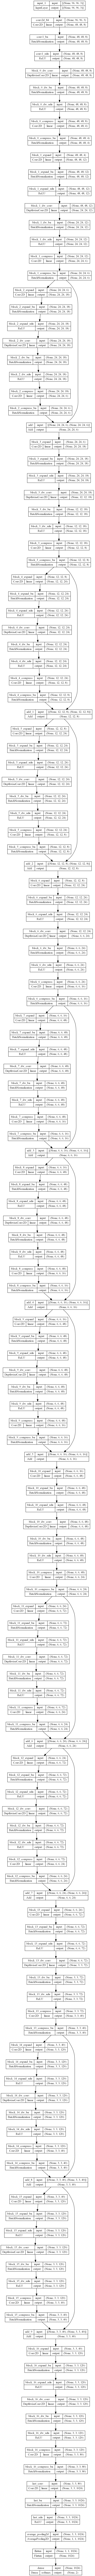

In [210]:
tf.keras.utils.plot_model(
    model,
    to_file=models_image_path,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",  # TB for vertical plot, LR for horizontal plot
    expand_nested=True,
    layer_range=None,
    dpi=200,
    show_layer_activations=True,
)

# Save the model summary


In [211]:
mltk_summary = summarize_model(model)
print(mltk_summary)


Model: "mobilenetv2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_84 (Conv2D)             (None, 48, 48, 8)    216         ['input_1[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 48, 48, 8)    32          ['conv2d_84[0][0]']              
                                                                                                  
 conv1_relu (ReLU)              (None, 48, 48, 8)    0           ['conv1_bn[0][0]']               
                                                                                        

In [212]:
# save the model summary to disk

from contextlib import redirect_stdout

with open(models_summary_path, "w", encoding='utf-8') as f:
    with redirect_stdout(f):
        print(mltk_summary)

# Save the model

In [213]:
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# #model.save("everything/model", save_format="tf")

In [214]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.save(models_tf_path) #, save_format="tf")
models_tf_path

WindowsPath('c:/tiny_mlc/tiny_cnn/models/mobilenetv2_0.25_96_c3_o2_t3l1024.MV1/mobilenetv2_0.25_96_c3_o2_t3l1024.MV1.h5')

In [215]:
#models_tf_path_pb.is_dir()

In [216]:
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# model.save("my_model", save_format="tf")
# models_tf_path_pb

In [217]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(5, input_shape=(3,)),
#     tf.keras.layers.Softmax()])
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# model.save("model.keras")
# loaded_model = tf.keras.models.load_model("model.keras")
# x = tf.random.uniform((10, 3))
# assert np.allclose(model.predict(x), loaded_model.predict(x))

In [218]:
with open("analyzer_list.txt", "a") as f:
    f.write(f"{model_name}\n")

In [219]:
if automated == False:

    ! explorer $models_path

In [220]:
#! explorer $models_path

# Building fractional models

In [221]:
# from tensorflow.keras.applications.ResNet50 import ResNet50
# from tensorflow.keras.models import Model

# base_model = ResNet50(weights='imagenet', include_top=True)
# ResNet14 = Model(inputs = base_model.input,outputs = base_model.get_layer('conv2_block1_0_conv').output)

# Linux playground

In [222]:
#! wsl ls ./models

In [223]:
# ! wsl pwd

In [224]:
# ! wsl ls ./models -l >model.txt

In [225]:
#! wsl ls ./models -laR 

In [226]:
#linux_path = models_tflite_path.as_posix()

In [227]:
models_tf_path

WindowsPath('c:/tiny_mlc/tiny_cnn/models/mobilenetv2_0.25_96_c3_o2_t3l1024.MV1/mobilenetv2_0.25_96_c3_o2_t3l1024.MV1.h5')